In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM,Activation,Dropout
from sklearn.metrics import mean_squared_error

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from math import sqrt
import matplotlib.pyplot as plt

# ⬇ Tambahkan di sini
import os
import random
import tensorflow as tf

seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


In [4]:
import pandas as pd
df = pd.read_excel('DATA_SKRIP.xlsx')

df.head()


,TANGGAL,FF_X
0,2014-01-01,7.0
1,2014-01-02,6.0
2,2014-01-03,5.0
3,2014-01-04,6.0
4,2014-01-05,6.0


In [5]:
for col in df.columns:
    missing_count = df[col].isnull().sum()
    if missing_count > 0:
        print(f"\nColumn '{col}' has {missing_count} missing values.")


Column 'FF_X' has 11 missing values.


In [6]:
rows_with_missing_ffx = df[df['FF_X'].isnull()]
rows_with_missing_ffx


,TANGGAL,FF_X
407,2015-02-12,NaN
419,2015-02-24,NaN
420,2015-02-25,NaN
421,2015-02-26,NaN
422,2015-02-27,NaN
497,2015-05-13,NaN
2168,2019-12-09,NaN
2172,2019-12-13,NaN
2180,2019-12-21,NaN
2185,2019-12-26,NaN


In [7]:
df.isnull().sum()

,0
TANGGAL,0
FF_X,11


Menangani missing value dilakukan dengan imputasi menggunakan pola musiman. Dalam hal data cuaca, data dibagi berdasarkan 4 musim: DJF (Desember-Januari-Februari), MAM (Maret-April-Mei), JJA (Juni-Juli-Agustus), dan SON (September-Oktober-November).

# MENGELOMPOKKAN BERDASARKAN MUSIM


In [8]:
# Menambah kolom Bulan
df['TANGGAL'] = pd.to_datetime(df['TANGGAL'])
df['Bulan'] = df['TANGGAL'].dt.month

# Menambah kolom musim
def determine_season(month):
    if month in [12, 1, 2]:
        return 'HUJAN'
    elif month in [3, 4, 5]:
        return 'PANCAROBA I'
    elif month in [6, 7, 8]:
        return 'KEMARAU'
    elif month in [9, 10, 11]:
        return 'PANCAROBA II'

df['Musim'] = df['Bulan'].apply(determine_season)

# Mengelompokkan data berdasarkan musim
grouped = df.groupby('Musim').agg({
    'FF_X': ['mean', 'max', 'min'],  # Statistik contoh
}).reset_index()

grouped

Musim      FF_X           
                     mean   max  min
0         HUJAN  6.597502  18.0  0.0
1       KEMARAU  6.066855  11.0  2.0
2   PANCAROBA I  5.533998  21.0  2.0
3  PANCAROBA II  6.409590  16.0  3.0

In [9]:
df.head()

,TANGGAL,FF_X,Bulan,Musim
0,2014-01-01,7.0,1,HUJAN
1,2014-01-02,6.0,1,HUJAN
2,2014-01-03,5.0,1,HUJAN
3,2014-01-04,6.0,1,HUJAN
4,2014-01-05,6.0,1,HUJAN


# HANDLING MISSING VALUE PER MUSIM YANG SUDAH DIKELOMPOKKAN

## PENGECEKAN MISSING VALUE

In [10]:

missing_rows = df[df.isnull().any(axis=1)]
missing_by_group = missing_rows.groupby('Musim')

for group, rows in missing_by_group:
    print(f"Missing values in group '{group}':")
    print(rows)
    print("-" * 50)

Missing values in group 'HUJAN':
        TANGGAL  FF_X  Bulan  Musim
407  2015-02-12   NaN      2  HUJAN
419  2015-02-24   NaN      2  HUJAN
420  2015-02-25   NaN      2  HUJAN
421  2015-02-26   NaN      2  HUJAN
422  2015-02-27   NaN      2  HUJAN
2168 2019-12-09   NaN     12  HUJAN
2172 2019-12-13   NaN     12  HUJAN
2180 2019-12-21   NaN     12  HUJAN
2185 2019-12-26   NaN     12  HUJAN
2188 2019-12-29   NaN     12  HUJAN
--------------------------------------------------
Missing values in group 'PANCAROBA I':
       TANGGAL  FF_X  Bulan        Musim
497 2015-05-13   NaN      5  PANCAROBA I
--------------------------------------------------


In [11]:
mean_ff_x = df.groupby('Musim')['FF_X'].mean()

result = pd.DataFrame({
    'Mean_ff_x': mean_ff_x,
})

result

,Mean_ff_x
Musim,
HUJAN,6.597502
KEMARAU,6.066855
PANCAROBA I,5.533998
PANCAROBA II,6.409590


## MENGATASI MISSING VALUE DENGAN MEAN

In [12]:
def fill_missing_values(group):
    group['FF_X'] = group['FF_X'].fillna(group['FF_X'].mean())
    return group

df_filled = df.groupby('Musim').apply(fill_missing_values)
df_filled

/tmp/ipython-input-12-293283366.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby('Musim').apply(fill_missing_values)


TANGGAL  FF_X  Bulan         Musim
Musim                                                  
HUJAN        0    2014-01-01   7.0      1         HUJAN
             1    2014-01-02   6.0      1         HUJAN
             2    2014-01-03   5.0      1         HUJAN
             3    2014-01-04   6.0      1         HUJAN
             4    2014-01-05   6.0      1         HUJAN
...                      ...   ...    ...           ...
PANCAROBA II 3982 2024-11-26   4.0     11  PANCAROBA II
             3983 2024-11-27   7.0     11  PANCAROBA II
             3984 2024-11-28   7.0     11  PANCAROBA II
             3985 2024-11-29   8.0     11  PANCAROBA II
             3986 2024-11-30   5.0     11  PANCAROBA II

[4218 rows x 4 columns]

In [13]:
df_filled = df.groupby('Musim').apply(fill_missing_values)
df_filled.reset_index(drop=True, inplace=True)  # Opsional: reset index setelah groupby


/tmp/ipython-input-13-3748491759.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filled = df.groupby('Musim').apply(fill_missing_values)


In [14]:
df_filled

,TANGGAL,FF_X,Bulan,Musim
0,2014-01-01,7.0,1,HUJAN
1,2014-01-02,6.0,1,HUJAN
2,2014-01-03,5.0,1,HUJAN
3,2014-01-04,6.0,1,HUJAN
4,2014-01-05,6.0,1,HUJAN
...,...,...,...,...
4213,2024-11-26,4.0,11,PANCAROBA II
4214,2024-11-27,7.0,11,PANCAROBA II
4215,2024-11-28,7.0,11,PANCAROBA II
4216,2024-11-29,8.0,11,PANCAROBA II


In [15]:
print(df_filled.head())

     TANGGAL  FF_X  Bulan  Musim
0 2014-01-01   7.0      1  HUJAN
1 2014-01-02   6.0      1  HUJAN
2 2014-01-03   5.0      1  HUJAN
3 2014-01-04   6.0      1  HUJAN
4 2014-01-05   6.0      1  HUJAN


In [16]:
df_filled.isnull().sum()

,0
TANGGAL,0
FF_X,0
Bulan,0
Musim,0


## MERGE DATAFRAME

### menggabungkan dataframe dengan menggunakan index asli dataframe awal

In [17]:
dfs = {}
for season, group in df_filled.groupby('Musim'):
    dfs[season] = group

# Access each dataframe using the season as the key
# Example: Access the dataframe for the 'DJF' season
djf_df = dfs['HUJAN']
print(djf_df.head())

mam_df = dfs['PANCAROBA I']
print(mam_df.head())

jja_df = dfs['KEMARAU']
print(jja_df.head())

son_df = dfs['PANCAROBA II']
print(son_df.head())

     TANGGAL  FF_X  Bulan  Musim
0 2014-01-01   7.0      1  HUJAN
1 2014-01-02   6.0      1  HUJAN
2 2014-01-03   5.0      1  HUJAN
3 2014-01-04   6.0      1  HUJAN
4 2014-01-05   6.0      1  HUJAN
        TANGGAL  FF_X  Bulan        Musim
2113 2014-03-01   5.0      3  PANCAROBA I
2114 2014-03-02   5.0      3  PANCAROBA I
2115 2014-03-03   4.0      3  PANCAROBA I
2116 2014-03-04   8.0      3  PANCAROBA I
2117 2014-03-05   5.0      3  PANCAROBA I
        TANGGAL  FF_X  Bulan    Musim
1051 2014-06-01   5.0      6  KEMARAU
1052 2014-06-02   4.0      6  KEMARAU
1053 2014-06-03   5.0      6  KEMARAU
1054 2014-06-04   6.0      6  KEMARAU
1055 2014-06-05   7.0      6  KEMARAU
        TANGGAL  FF_X  Bulan         Musim
3217 2014-09-01   6.0      9  PANCAROBA II
3218 2014-09-02   6.0      9  PANCAROBA II
3219 2014-09-03   5.0      9  PANCAROBA II
3220 2014-09-04   5.0      9  PANCAROBA II
3221 2014-09-05   7.0      9  PANCAROBA II


### menggabungkan dataframe dengan mengurutkan index tiap musim

In [18]:

df_selected = df_filled[['TANGGAL', 'FF_X', 'Musim']]

df_selected = df_selected.set_index('TANGGAL')

dfs = {}
for season, group in df_selected.groupby('Musim'):
    dfs[season] = group.reset_index()

for season, df in dfs.items():
    print(f"Dataframe for season: {season}")
    print(df)
    print("-" * 50)

Dataframe for season: HUJAN
        TANGGAL  FF_X  Musim
0    2014-01-01   7.0  HUJAN
1    2014-01-02   6.0  HUJAN
2    2014-01-03   5.0  HUJAN
3    2014-01-04   6.0  HUJAN
4    2014-01-05   6.0  HUJAN
...         ...   ...    ...
1046 2025-02-24   6.0  HUJAN
1047 2025-02-25   4.0  HUJAN
1048 2025-02-26   3.0  HUJAN
1049 2025-02-27   4.0  HUJAN
1050 2025-02-28   5.0  HUJAN

[1051 rows x 3 columns]
--------------------------------------------------
Dataframe for season: KEMARAU
        TANGGAL  FF_X    Musim
0    2014-06-01   5.0  KEMARAU
1    2014-06-02   4.0  KEMARAU
2    2014-06-03   5.0  KEMARAU
3    2014-06-04   6.0  KEMARAU
4    2014-06-05   7.0  KEMARAU
...         ...   ...      ...
1057 2025-07-16   5.0  KEMARAU
1058 2025-07-17   4.0  KEMARAU
1059 2025-07-18   5.0  KEMARAU
1060 2025-07-19   4.0  KEMARAU
1061 2025-07-20   4.0  KEMARAU

[1062 rows x 3 columns]
--------------------------------------------------
Dataframe for season: PANCAROBA I
        TANGGAL  FF_X        Musim
0

### menggabungkan dataframe dengan mengurutkan index keseluruhan dari 0

In [19]:
# Gabungkan semua data per musim kembali jadi satu DataFrame
df_musim = pd.concat(dfs.values(), ignore_index=True)

# Tampilkan beberapa baris pertama
print(df_musim.head(5000))


        TANGGAL  FF_X         Musim
0    2014-01-01   7.0         HUJAN
1    2014-01-02   6.0         HUJAN
2    2014-01-03   5.0         HUJAN
3    2014-01-04   6.0         HUJAN
4    2014-01-05   6.0         HUJAN
...         ...   ...           ...
4213 2024-11-26   4.0  PANCAROBA II
4214 2024-11-27   7.0  PANCAROBA II
4215 2024-11-28   7.0  PANCAROBA II
4216 2024-11-29   8.0  PANCAROBA II
4217 2024-11-30   5.0  PANCAROBA II

[4218 rows x 3 columns]


In [20]:
df_musim = df_musim.sort_values('TANGGAL').reset_index(drop=True)


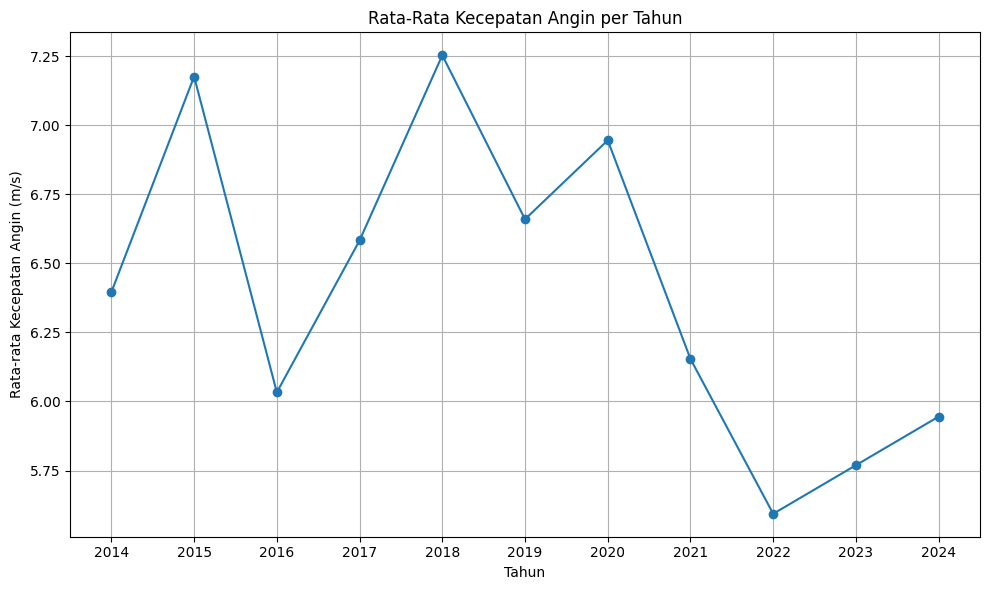

In [21]:
import matplotlib.pyplot as plt
df['tahun'] = df['TANGGAL'].dt.year

rata_tahunan = df.groupby('tahun')['FF_X'].mean()

plt.figure(figsize=(10, 6))
plt.plot(rata_tahunan.index, rata_tahunan.values, marker='o')
plt.xlabel('Tahun')
plt.ylabel('Rata-rata Kecepatan Angin (m/s)')
plt.title('Rata-Rata Kecepatan Angin per Tahun')
plt.grid(True)
plt.xticks(rata_tahunan.index)  # Supaya label tahun jelas
plt.tight_layout()
plt.show()


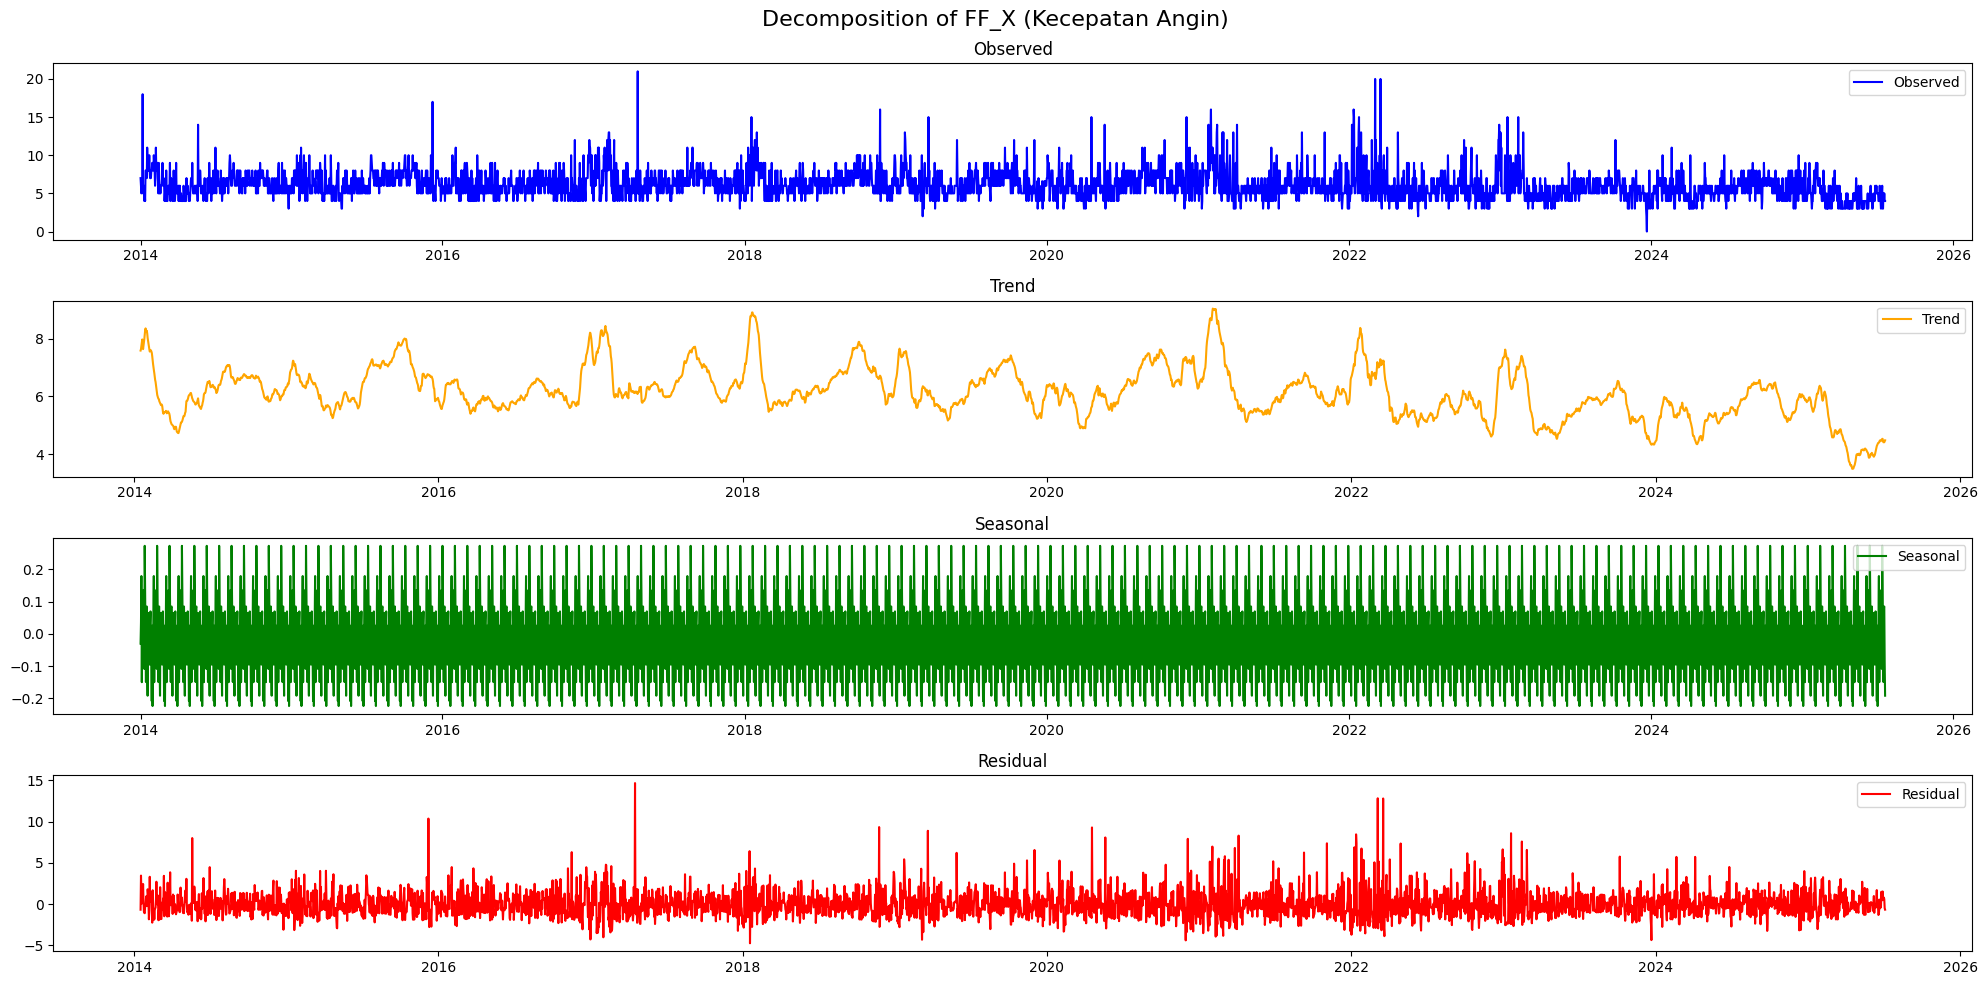

In [22]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Pastikan kolom 'TANGGAL' bertipe datetime dan menjadi index
df_musim['TANGGAL'] = pd.to_datetime(df_musim['TANGGAL'])
df_musim = df_musim.set_index('TANGGAL')

# Ambil hanya kolom FF_X (kecepatan angin)
ts = df_musim['FF_X'].dropna()  # Hilangkan NaN jika ada

# Melakukan dekomposisi musiman
# Gantilah period=365 jika data harian dan kamu ingin dekomposisi tahunan
# Jika musiman per 3 bulanan atau 4 bulanan, sesuaikan misalnya: 90 atau 120
result = seasonal_decompose(ts, model='additive', period=30)  # 30 untuk kira-kira 1 bulan musiman

# Visualisasi hasil dekomposisi
plt.figure(figsize=(20, 10))

plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Observed', color='blue')
plt.title('Observed')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual')
plt.legend()

plt.suptitle('Decomposition of FF_X (Kecepatan Angin)', fontsize=16)
plt.tight_layout()
plt.show()


- Komponen ini menunjukkan nilai asli kecepatan angin dari tahun 2013 hingga 2025. Terlihat bahwa nilai kecepatan angin mengalami fluktuasi yang signifikan dari waktu ke waktu. Beberapa lonjakan ekstrem menandakan adanya peningkatan mendadak kecepatan angin, yang kemungkinan besar disebabkan oleh faktor musiman atau kejadian cuaca ekstrem.
- Tren jangka panjang menunjukkan pergerakan umum kecepatan angin dalam periode waktu yang lebih luas. Dari grafik, terlihat bahwa tren mengalami perubahan: pada awalnya menunjukkan sedikit peningkatan hingga sekitar tahun 2021, kemudian mengalami sedikit penurunan dan stabilisasi. Hal ini mengindikasikan bahwa kecepatan angin tidak memiliki pola tren linier yang kuat secara keseluruhan.
- Komponen seasonal menunjukkan adanya pola berulang yang konsisten sepanjang tahun. Pola ini muncul secara periodik, menandakan bahwa terdapat pengaruh musiman yang kuat terhadap kecepatan angin. Hal ini sejalan dengan kondisi iklim di wilayah tropis seperti Indonesia yang memiliki variasi musiman yang khas, seperti musim hujan, kemarau, dan pancaroba.
- Komponen residual menggambarkan variasi data yang tidak dapat dijelaskan oleh trend maupun pola musiman. Pada grafik residual, terdapat beberapa lonjakan tajam yang mengindikasikan adanya outlier atau anomali. Namun, secara umum nilai residual tersebar cukup merata di sekitar nol, yang menunjukkan bahwa model dekomposisi sudah cukup baik dalam memisahkan komponen utama data.

# Stationary Test
Untuk memastikan data time series stasioner, kita menggunakan metode ADF (Augmented Dickey-Fuller) Test. Data stasioner penting untuk pemodelan time series yang akurat.

=== Hasil Uji ADF untuk FF_X ===
ADF Statistic : -7.9300
p-value       : 0.0000
Critical Values:
   1% : -3.4319
   5% : -2.8622
   10% : -2.5671
✅ Data stasioner (tolak H0)


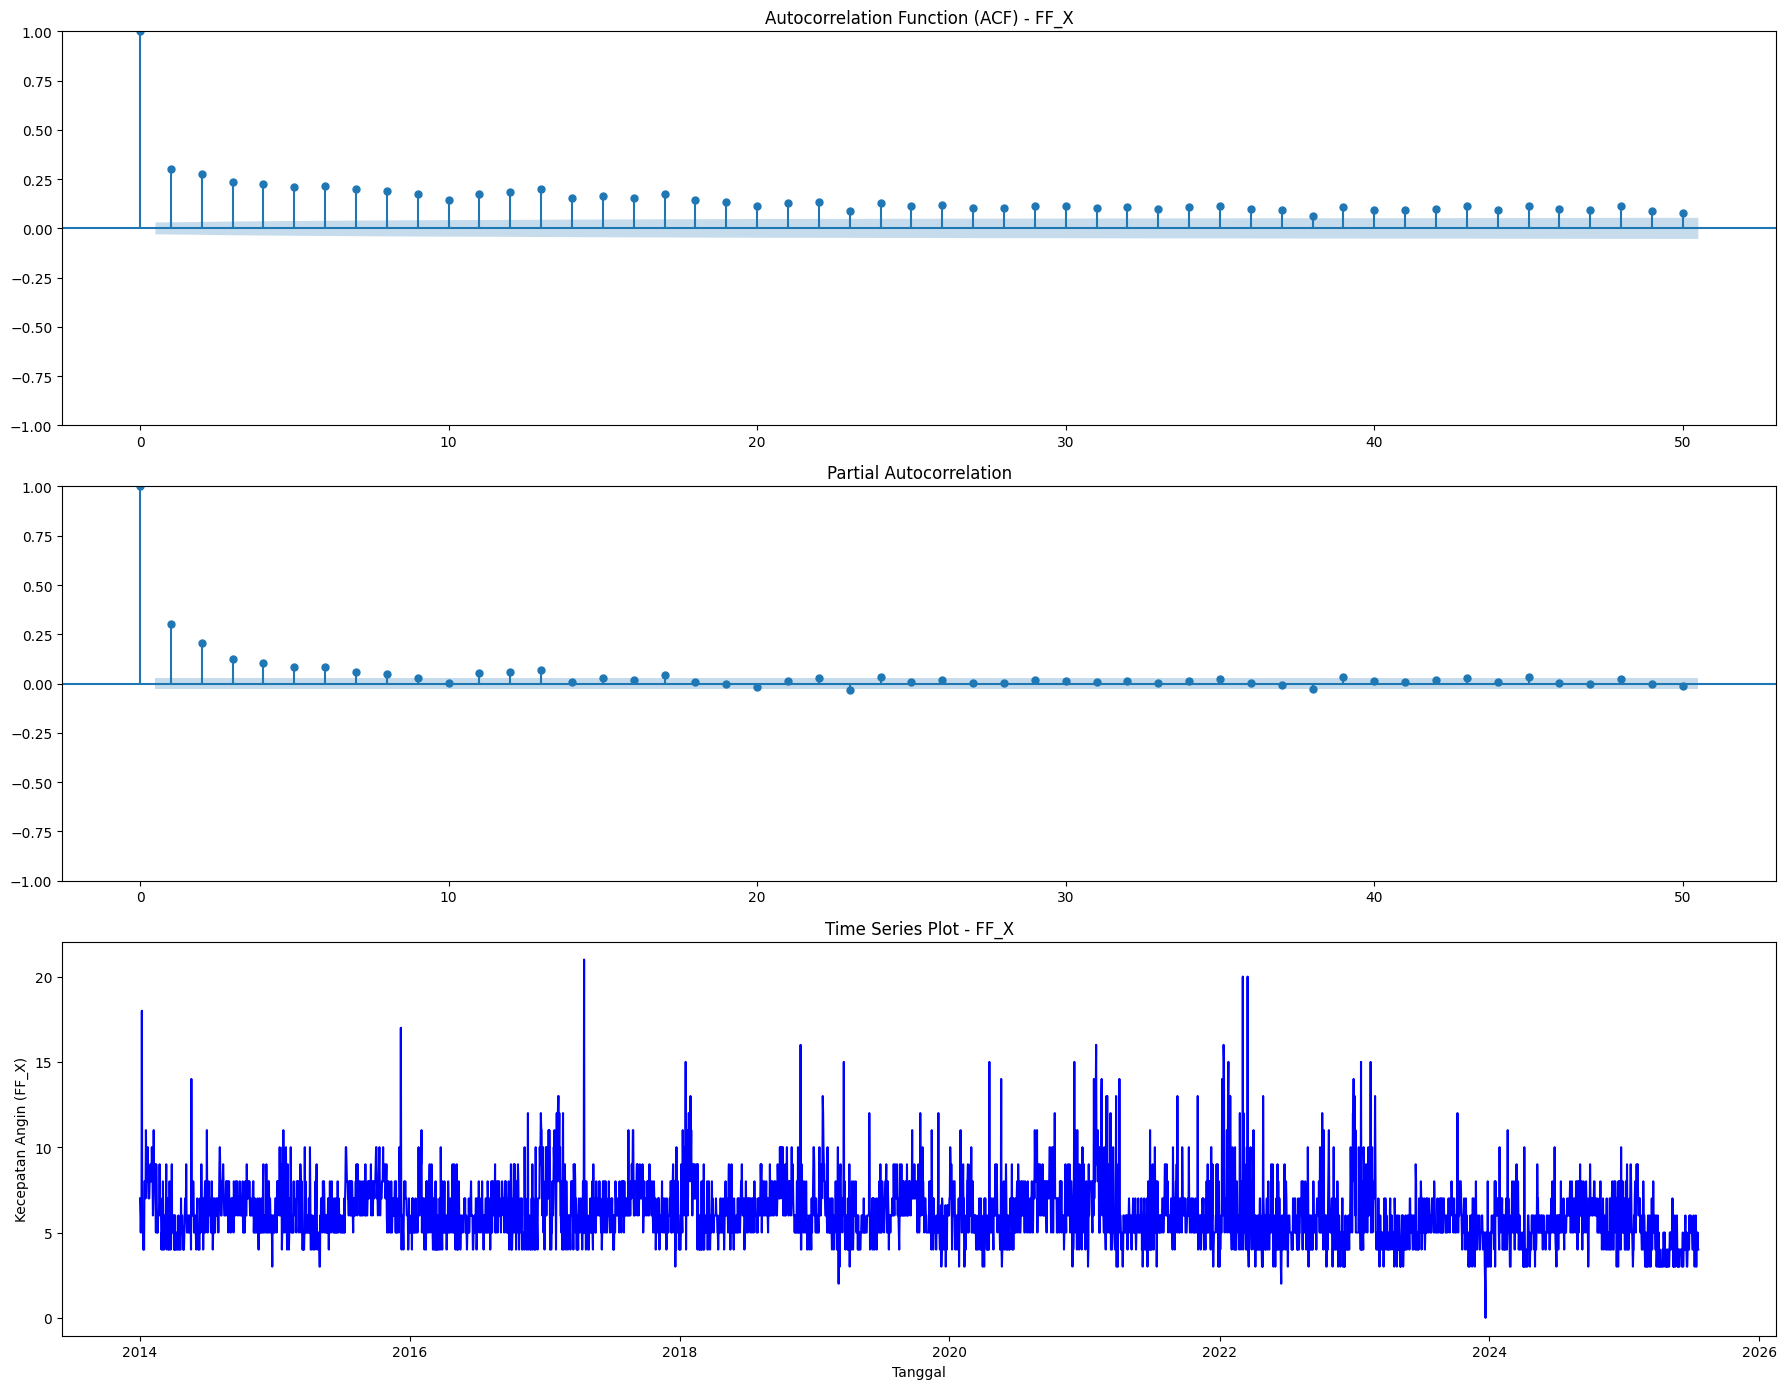

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# --- Ambil hanya kolom FF_X dan drop NaN ---
ts = df_musim['FF_X'].dropna()

# --- Uji Stasioneritas: Augmented Dickey-Fuller (ADF) ---
result = adfuller(ts, autolag='AIC')
print('=== Hasil Uji ADF untuk FF_X ===')
print(f'ADF Statistic : {result[0]:.4f}')
print(f'p-value       : {result[1]:.4f}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'   {key} : {value:.4f}')
if result[1] <= 0.05:
    print("✅ Data stasioner (tolak H0)")
else:
    print("⚠️ Data tidak stasioner (gagal tolak H0)")

# --- Plot ACF, PACF, dan Time Series ---
fig, axes = plt.subplots(3, 1, figsize=(18, 14))
plt.subplots_adjust(hspace=0.5)

# ACF
plot_acf(ts, lags=50, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF) - FF_X')

# PACF
plot_pacf(ts, lags=50, ax=axes[1], method='ywm')  # gunakan method='ywm' untuk kestabilan

# Time Series
axes[2].plot(ts, color='blue')
axes[2].set_title('Time Series Plot - FF_X')
axes[2].set_xlabel('Tanggal')
axes[2].set_ylabel('Kecepatan Angin (FF_X)')

plt.tight_layout()
plt.show()


Lag ke-6 dipilih sebagai lag optimal karena berdasarkan plot ACF, nilai autokorelasi signifikan hanya sampai lag ke-6. Meskipun batang pada lag 7 ke atas masih muncul, namun tidak melewati batas signifikansi sehingga dianggap tidak memiliki kontribusi berarti terhadap prediksi nilai saat ini.



# MODELING

## Feature Scaling
Agar semua fitur berada dalam skala yang sama dan mempercepat konvergensi model, kita akan menggunakan metode MinMaxScaler. Metode ini akan mengubah nilai fitur menjadi rentang 0 hingga 1.

In [24]:
# ensure all data is float
# Select only the numerical column 'FF_X' before converting to numpy array
values = df_musim['FF_X'].values
values = values.astype('float32')
values

array([7., 6., 5., ..., 5., 4., 4.], dtype=float32)

In [25]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
# Reshape the 1D array to a 2D array before scaling
scaled_values = scaler.fit_transform(values.reshape(-1, 1))
scaled_values

array([[0.33333334],
       [0.2857143 ],
       [0.23809524],
       ...,
       [0.23809524],
       [0.1904762 ],
       [0.1904762 ]], dtype=float32)

## Pemisahan Data Train dan Test
Dataset akan dibagi menjadi dua bagian: 80% untuk data pelatihan (train) dan 20% untuk data pengujian (test). Pembagian ini memastikan bahwa model dapat dilatih dengan cukup data dan diuji untuk mengevaluasi performanya.

In [26]:
# Membagi data dengan test size 0.2 dan tanpa shuffle
df_train, df_test = train_test_split(df_musim, test_size=0.2, shuffle=False)

print('Data for train:', df_train.shape)
print('\nData for test:', df_test.shape)

Data for train: (3374, 2)

Data for test: (844, 2)


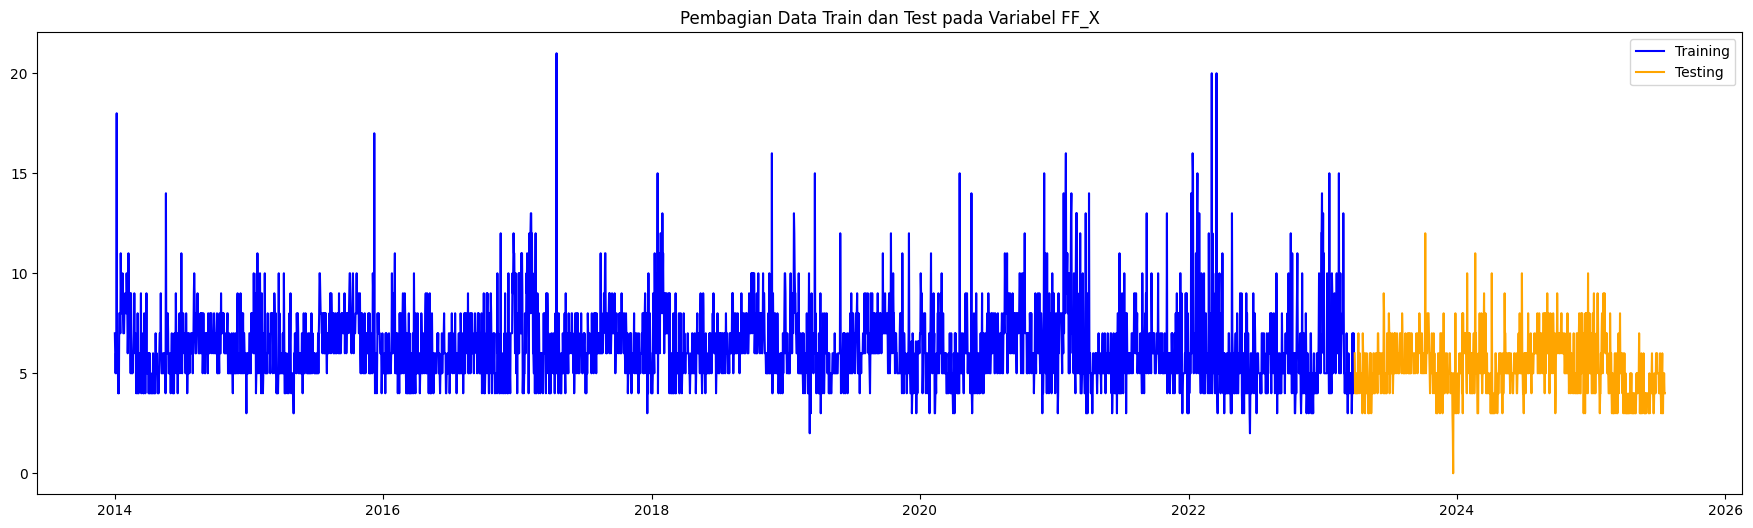

In [27]:
features = ['FF_X']
for feature in features:
    plt.figure(figsize=(22,6))
    # Plot df_train in blue
    plt.plot(df_train.index, df_train[feature], label='Training', color='blue')
    # Plot df_test in orange
    plt.plot(df_test.index, df_test[feature], label='Testing', color='orange')
    plt.title(f'Pembagian Data Train dan Test pada Variabel {feature}')
    plt.legend(loc='upper right')  # Add legend

## mengubah data deret waktu menjadi supervised learning, menentukan lag dan target

## Pembuatan Sequence Window
Untuk memodelkan data time series, kita akan membuat jendela urutan (sequence window) menggunakan metode series_to_supervised. Metode ini akan mengubah data time series menjadi format yang dapat digunakan oleh model LSTM, di mana  menggunakan data dari 6 hari sebelumnya untuk memprediksi 1 hari selanjutnya.

In [28]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    df = pd.DataFrame(data)
    n_vars = df.shape[1]
    cols, names = [], []

    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [f'var{j+1}(t-{i})' for j in range(n_vars)]

    # forecast sequence (t, t+1, ..., t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [f'var{j+1}(t)' for j in range(n_vars)]
        else:
            names += [f'var{j+1}(t+{i})' for j in range(n_vars)]

    agg = pd.concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [29]:
df_musim.head(5000)

,FF_X,Musim
TANGGAL,,
2014-01-01,7.0,HUJAN
2014-01-02,6.0,HUJAN
2014-01-03,5.0,HUJAN
2014-01-04,6.0,HUJAN
2014-01-05,6.0,HUJAN
...,...,...
2025-07-16,5.0,KEMARAU
2025-07-17,4.0,KEMARAU
2025-07-18,5.0,KEMARAU


In [30]:
# Select only the numerical column 'FF_X' before converting to numpy array
data=df_musim['FF_X'].values
print(df_musim.FF_X.min()) #melihat nilai terkecil dari kecepatan angin di data.
df_musim.FF_X.max() #nilai terbesar (hasil ini tidak ditampilkan karena tidak dicetak).

0.0


21.0

In [31]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# standarisasi features
scaler=MinMaxScaler(feature_range=(0,1))
# Select only the 'FF_X' column for scaling
scaled = scaler.fit_transform(df_musim[['FF_X']])

In [32]:
n_days = 6
n_features = 1

In [33]:

reframed = series_to_supervised(scaled, n_days, 1)
print(reframed.shape)


(4212, 7)


In [34]:

print(reframed)

      var1(t-6)  var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)  \
6      0.333333   0.285714   0.238095   0.285714   0.285714   0.857143   
7      0.285714   0.238095   0.285714   0.285714   0.857143   0.238095   
8      0.238095   0.285714   0.285714   0.857143   0.238095   0.285714   
9      0.285714   0.285714   0.857143   0.238095   0.285714   0.285714   
10     0.285714   0.857143   0.238095   0.285714   0.285714   0.190476   
...         ...        ...        ...        ...        ...        ...   
4213   0.142857   0.190476   0.238095   0.285714   0.142857   0.142857   
4214   0.190476   0.238095   0.285714   0.142857   0.142857   0.238095   
4215   0.238095   0.285714   0.142857   0.142857   0.238095   0.190476   
4216   0.285714   0.142857   0.142857   0.238095   0.190476   0.238095   
4217   0.142857   0.142857   0.238095   0.190476   0.238095   0.190476   

       var1(t)  
6     0.238095  
7     0.285714  
8     0.285714  
9     0.190476  
10    0.238095  
...      

In [35]:
values = reframed.values

### SPLITTING DATA

In [36]:
from sklearn.model_selection import train_test_split

# Ambil nilai dari dataframe hasil reframing
values = reframed.values

# Simpan index tanggal dari hasil reframing
date_reframed = df_musim.index[reframed.index]

# Membagi data dengan test size 0.2 dan tanpa shuffle
train_size = int(len(values) * 0.8)
train, test = values[:train_size], values[train_size:]

# Bagi juga indeks tanggal sesuai panjang data train dan test
date_train = date_reframed[:len(train)]
date_test = date_reframed[len(train):]

# Cek hasil
print("Jumlah data:", len(values))
print("Jumlah train :", len(train), "Tanggal:", date_train.min(), "s.d.", date_train.max())
print("Jumlah test  :", len(test),  "Tanggal:", date_test.min(),  "s.d.", date_test.max())


Jumlah data: 4212
Jumlah train : 3369 Tanggal: 2014-01-07 00:00:00 s.d. 2023-03-29 00:00:00
Jumlah test  : 843 Tanggal: 2023-03-30 00:00:00 s.d. 2025-07-20 00:00:00


In [37]:
# --- Jumlah input (lag) dan fitur per timestep ---
n_obs = n_days * n_features  # jumlah kolom input

# --- Pisahkan input (X) dan target (y) ---
train_X, train_y = train[:, :n_obs], train[:, -1]  # target ambil kolom terakhir (var1(t))
test_X, test_y = test[:, :n_obs], test[:, -1]

# --- Bentuk ulang menjadi 3D untuk input LSTM (samples, timesteps, features) ---
X_train = train_X.reshape((train_X.shape[0], n_days, n_features))
X_test = test_X.reshape((test_X.shape[0], n_days, n_features))

# --- Reshape y agar sama format (opsional: tetap 2D) ---
y_train = train_y.reshape(-1, 1)
y_test = test_y.reshape(-1, 1)

# --- Cek hasil ---
print('Total fitur per timestep  :', n_features)
print('X_train shape             :', X_train.shape)
print('y_train shape             :', y_train.shape)
print('X_test shape              :', X_test.shape)
print('y_test shape              :', y_test.shape)


Total fitur per timestep  : 1
X_train shape             : (3369, 6, 1)
y_train shape             : (3369, 1)
X_test shape              : (843, 6, 1)
y_test shape              : (843, 1)


In [38]:
# Look at the x_train structure
print('Data input structure for training')
print(X_train[0])

print('\nData output structure for validation')
print(y_train[0])

Data input structure for training
[[0.33333333]
 [0.28571429]
 [0.23809524]
 [0.28571429]
 [0.28571429]
 [0.85714286]]

Data output structure for validation
[0.23809524]


### menghitung jumlah node pada hidden layer

In [39]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import Adam

# Define model
model1 = Sequential()
model1.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model1.add(Dropout(0.3)) # Dropout regularisation
model1.add(LSTM(10, return_sequences=False))
model1.add(Dropout(0.3)) # Dropout regularisation
model1.add(Flatten())
model1.add(Dense(64, activation="relu"))
model1.add(Dense(16, activation="relu"))
model1.add(Dense(n_features))

optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10)             │         2,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,601 (57.04 KB)

 Trainable params: 14,601 (57.04 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint

def train_model(model, X_train, y_train, X_test, y_test,
                learning_rate=0.001, batch_size=32, epochs=100,
                patience=3, filepath='best_model.h5'):

    # Define learning rate scheduler
    def scheduler(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return float(lr * tf.math.exp(-0.1 * (epoch - 9)))   # Decay learning rate more aggressively and ensure float output

    lr_scheduler = LearningRateScheduler(scheduler)
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    checkpointer = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=True)

    # Fit the model
    history = model.fit(X_train, y_train, epochs=epochs,
                        batch_size=batch_size, validation_data=(X_test, y_test),
                        callbacks=[lr_scheduler, early_stopping, checkpointer],
                        verbose=1, shuffle=False)

    # Evaluate the model
    test_loss = model.evaluate(X_test, y_test)
    print(f'Test Loss: {test_loss}')

    # Plot training history
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return history, test_loss

Epoch 1/100
102/106 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0292 - mae: 0.1321
Epoch 1: val_loss improved from inf to 0.00435, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0285 - mae: 0.1301 - val_loss: 0.0043 - val_mae: 0.0516 - learning_rate: 0.0010
Epoch 2/100
101/106 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0064 - mae: 0.0605
Epoch 2: val_loss did not improve from 0.00435
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0065 - mae: 0.0608 - val_loss: 0.0045 - val_mae: 0.0522 - learning_rate: 0.0010
Epoch 3/100
103/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0601
Epoch 3: val_loss did not improve from 0.00435
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0063 - mae: 0.0602 - val_loss: 0.0044 - val_mae: 0.0521 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0062 - mae: 0.0597
Epoch 4: val_loss did not improve from 0.00435
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0062 - mae: 0.0597 - val_loss: 0.0044 - val_mae: 0.0527 - learning_rate: 0.0010
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0038 - mae: 0.0479
Test Loss: [0.0043

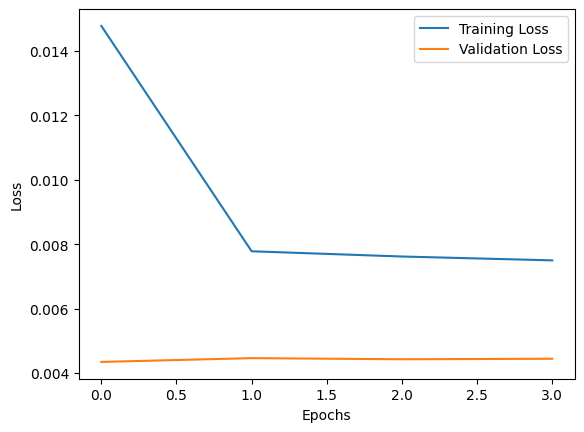

In [42]:
# Train the model
history1, test_loss1 = train_model(model1, X_train, y_train, X_test, y_test)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 6, 200)         │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 288,529 (1.10 MB)

 Trainable params: 288,529 (1.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0522 - mae: 0.1989
Epoch 1: val_loss improved from inf to 0.00412, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 0.0520 - mae: 0.1982 - val_loss: 0.0041 - val_mae: 0.0507 - learning_rate: 1.0000e-04
Epoch 2/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0060 - mae: 0.0580
Epoch 2: val_loss improved from 0.00412 to 0.00406, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0060 - mae: 0.0581 - val_loss: 0.0041 - val_mae: 0.0501 - learning_rate: 1.0000e-04
Epoch 3/100
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0059 - mae: 0.0578
Epoch 3: val_loss improved from 0.00406 to 0.00401, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - loss: 0.0060 - mae: 0.0579 - val_loss: 0.0040 - val_mae: 0.0496 - learning_rate: 1.0000e-04
Epoch 4/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0059 - mae: 0.0579
Epoch 4: val_loss improved from 0.00401 to 0.00398, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0059 - mae: 0.0580 - val_loss: 0.0040 - val_mae: 0.0492 - learning_rate: 1.0000e-04
Epoch 5/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0058 - mae: 0.0575
Epoch 5: val_loss improved from 0.00398 to 0.00398, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0059 - mae: 0.0576 - val_loss: 0.0040 - val_mae: 0.0492 - learning_rate: 1.0000e-04
Epoch 6/100
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0059 - mae: 0.0578
Epoch 6: val_loss improved from 0.00398 to 0.00396, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0059 - mae: 0.0579 - val_loss: 0.0040 - val_mae: 0.0490 - learning_rate: 1.0000e-04
Epoch 7/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0059 - mae: 0.0578
Epoch 7: val_loss did not improve from 0.00396
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0059 - mae: 0.0579 - val_loss: 0.0040 - val_mae: 0.0493 - learning_rate: 1.0000e-04
Epoch 8/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058 - mae: 0.0574
Epoch 8: val_loss did not improve from 0.00396
106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0059 - mae: 0.0575 - val_loss: 0.0040 - val_mae: 0.0491 - learning_rate: 1.0000e-04
Epoch 9/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0058 - mae: 0.0574
Epoch 9: val_loss improved from 0.00396 to 0.00395, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0058 - mae: 0.0575 - val_loss: 0.0040 - val_mae: 0.0490 - learning_rate: 1.0000e-04
Epoch 10/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0058 - mae: 0.0572
Epoch 10: val_loss did not improve from 0.00395
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0058 - mae: 0.0573 - val_loss: 0.0040 - val_mae: 0.0491 - learning_rate: 1.0000e-04
Epoch 11/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0059 - mae: 0.0578
Epoch 11: val_loss improved from 0.00395 to 0.00395, saving model to best_model.h5


106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0059 - mae: 0.0579 - val_loss: 0.0040 - val_mae: 0.0490 - learning_rate: 9.0484e-05
Epoch 12/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0058 - mae: 0.0573
Epoch 12: val_loss did not improve from 0.00395
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0058 - mae: 0.0573 - val_loss: 0.0040 - val_mae: 0.0495 - learning_rate: 7.4082e-05
Epoch 13/100
105/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0058 - mae: 0.0570
Epoch 13: val_loss did not improve from 0.00395
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0058 - mae: 0.0571 - val_loss: 0.0041 - val_mae: 0.0503 - learning_rate: 5.4881e-05
Epoch 14/100
104/106 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0057 - mae: 0.0569
Epoch 14: val_loss did not improve from 0.00395
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0057 - mae: 0.0570 - val_loss: 0.0042 - val_mae: 0.0512 - learning_rate: 3.6788e-05
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae

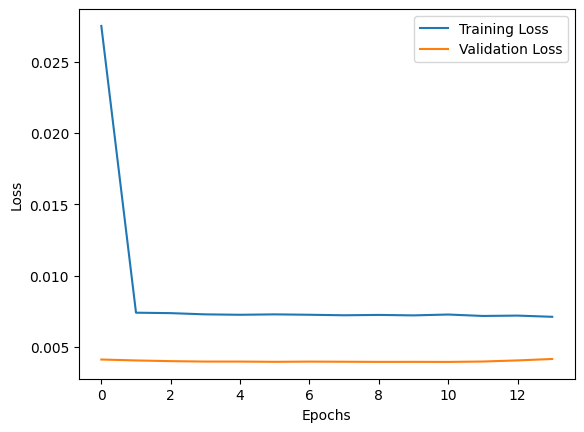

In [43]:
# Define model
model2 = Sequential()
model2.add(LSTM(200, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model2.add(Dropout(0.1)) # Dropout regularisation
model2.add(LSTM(100, return_sequences=False))
model2.add(Dropout(0.1)) # Dropout regularisation
model2.add(Dense(64, activation="relu"))
model2.add(Dense(n_features))

optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Menampilkan ringkasan model
model2.summary()

# Train the model
history2, test_loss2 = train_model(model2, X_train, y_train, X_test, y_test)

# Hyperparameter Tuning
Optimasi model LSTM akan dilakukan menggunakan Optuna, sebuah framework untuk melakukan hyperparameter tuning secara otomatis. Optuna akan mencoba berbagai kombinasi hyperparameter dan memilih yang terbaik berdasarkan kriteria performa yang ditentukan.

In [44]:
!pip install optuna


In [45]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define the objective function for Optuna
def objective(trial):
    lstm_units = trial.suggest_int('lstm_units', 10, 200)
    dense_units = trial.suggest_int('dense_units', 10, 200)
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    recurrent_dropout_rate = trial.suggest_float('recurrent_dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int('epochs', 20, 100)
    batch_size = trial.suggest_int('batch_size', 16, 128)

    # Define the model
    model = Sequential()
    model.add(LSTM(lstm_units, activation='relu', dropout=dropout_rate,
                   recurrent_dropout=recurrent_dropout_rate,
                   return_sequences=True,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, activation='relu',
                   dropout=dropout_rate,
                   recurrent_dropout=recurrent_dropout_rate))
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dense(n_features))

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(X_test, y_test), callbacks=[early_stopping],
              verbose=0, shuffle=False)

    # Evaluate the model
    loss = model.evaluate(X_test, y_test, verbose=0)
    return loss

# Create an Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)


[I 2025-07-21 06:45:44,716] A new study created in memory with name: no-name-42419da4-9194-4d01-b424-f4ba1f1d48b9
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-07-21 06:46:36,820] Trial 0 finished with value: 0.0045632487162947655 and parameters: {'lstm_units': 97, 'dense_units': 30, 'dropout_rate': 0.24654306104369506, 'recurrent_dropout_rate': 0.18213663787325118, 'learning_rate': 0.004570539360431914, 'epochs': 61, 'batch_size': 113}. Best is trial 0 with value: 0.0045632487162947655.
[I 2025-07-21 06:47:06,290] Trial 1 finished with value: 0.0043555921874940395 and parameters: {'lstm_units': 28, 'dense_units': 133, 'dropout_rate': 0.38945280622437856, 'recurrent_dropout_rate': 0.4375396747346828, 'learning_rate': 2.2872123853588014e-05, '

Best hyperparameters:  {'lstm_units': 199, 'dense_units': 116, 'dropout_rate': 0.0007883808480518839, 'recurrent_dropout_rate': 0.38133770701584846, 'learning_rate': 0.0009791251474657067, 'epochs': 52, 'batch_size': 85}


In [ ]:
# Train the final model with the best hyperparameters
best_params = study.best_params

tuned_model = Sequential()
tuned_model.add(LSTM(best_params['lstm_units'], activation='relu',
                     dropout=best_params['dropout_rate'],
                     recurrent_dropout=best_params['recurrent_dropout_rate'],
                     return_sequences=True, input_shape=(X_train.shape[1],
                                                         X_train.shape[2])))
tuned_model.add(Dropout(best_params['dropout_rate']))
tuned_model.add(LSTM(best_params['lstm_units'], activation='relu',
                      dropout=best_params['dropout_rate'],
                      recurrent_dropout=best_params['recurrent_dropout_rate']))
tuned_model.add(Dropout(best_params['dropout_rate']))
tuned_model.add(Dense(best_params['dense_units'], activation='relu'))
tuned_model.add(Dense(n_features))

# Compile the model
optimizer = Adam(learning_rate=best_params['learning_rate'])
tuned_model.compile(optimizer=optimizer, loss='mean_squared_error',
                    metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5,
                               restore_best_weights=True)

# Train the model
history = tuned_model.fit(X_train, y_train, epochs=best_params['epochs'],
                          batch_size=best_params['batch_size'],
                          validation_data=(X_test, y_test),
                          callbacks=[early_stopping], shuffle=False)

# Evaluate the model
test_loss = tuned_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 367ms/step - loss: 0.0441 - mae: 0.1749 - val_loss: 0.0054 - val_mae: 0.0601
Epoch 2/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 12s 141ms/step - loss: 0.0059 - mae: 0.0581 - val_loss: 0.0047 - val_mae: 0.0553
Epoch 3/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - loss: 0.0059 - mae: 0.0580 - val_loss: 0.0042 - val_mae: 0.0519
Epoch 4/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - loss: 0.0059 - mae: 0.0578 - val_loss: 0.0041 - val_mae: 0.0511
Epoch 5/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - loss: 0.0059 - mae: 0.0577 - val_loss: 0.0041 - val_mae: 0.0505
Epoch 6/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - loss: 0.0058 - mae: 0.0576 - val_loss: 0.0040 - val_mae: 0.0496
Epoch 7/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - loss: 0.0059 - mae: 0.0577 - val_loss: 0.0040 - val_mae: 0.0497
Epoch 8/52
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - loss: 0.0058 - mae: 0.0574 - val_loss: 0.0039 - val_mae: 0.0492
Epoch 9/52
 9/40 ━━━━━━━━━━━━━━━━━━━━ 3s 113ms/step 

In [47]:
def inverse_transform_and_plot(y_true, y_pred, scaler, features):
    """
    Inverse transforms the predictions and actual values, and plots them for each feature.

    Parameters:
    y_true (np.array): Actual values
    y_pred (np.array): Predicted values
    scaler (sklearn.preprocessing.StandardScaler): Scaler used for normalization
    features (list): List of feature names
    """
    inv_pred = scaler.inverse_transform(y_pred)
    inv_true = scaler.inverse_transform(y_true)

    for i in range(len(features)):
        plt.figure(figsize=(20, 8))
        plt.plot(inv_true[:, i], label='Actual')
        plt.plot(inv_pred[:, i], label='Predicted')
        plt.title(f'Actual vs Predicted for {features[i]}')
        plt.xlabel('Time')
        plt.ylabel(features[i])
        plt.legend()
        plt.show()

    return inv_true, inv_pred

In [48]:
import pandas as pd
import numpy as np

def create_predictions_dataframe(y_true, y_pred, feature_name='FF_X'):
    """
    Membuat DataFrame berisi nilai aktual dan prediksi untuk 1 fitur.

    Parameters:
    y_true (np.array): Nilai aktual (2D array: [samples, 1])
    y_pred (np.array): Nilai prediksi (2D array: [samples, 1])
    feature_name (str): Nama fitur target

    Returns:
    pd.DataFrame: DataFrame dengan kolom 'feature' dan 'feature_pred'
    """
    # Pastikan array-nya 1D
    y_true_flat = y_true.flatten()
    y_pred_flat = np.round(y_pred.flatten(), 3)

    # Buat DataFrame
    df_final = pd.DataFrame({
        f'{feature_name}': y_true_flat,
        f'{feature_name}_pred': y_pred_flat
    })

    return df_final


In [49]:
def calculate_metrics(y_true, y_pred, features):
    metrics = {
        'feature': [],
        'MAE': [],
        'R2': [],
        'RMSE': [],
        'MAPE': []
    }

    for i, feature in enumerate(features):
        actual = y_true[:, i].flatten()
        predicted = y_pred[:, i].flatten()

        mae = mean_absolute_error(actual, predicted)
        r2 = r2_score(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted))
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100

        metrics['feature'].append(feature)
        metrics['MAE'].append(mae)
        metrics['R2'].append(r2)
        metrics['RMSE'].append(rmse)
        metrics['MAPE'].append(mape)

    return pd.DataFrame(metrics)

27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step


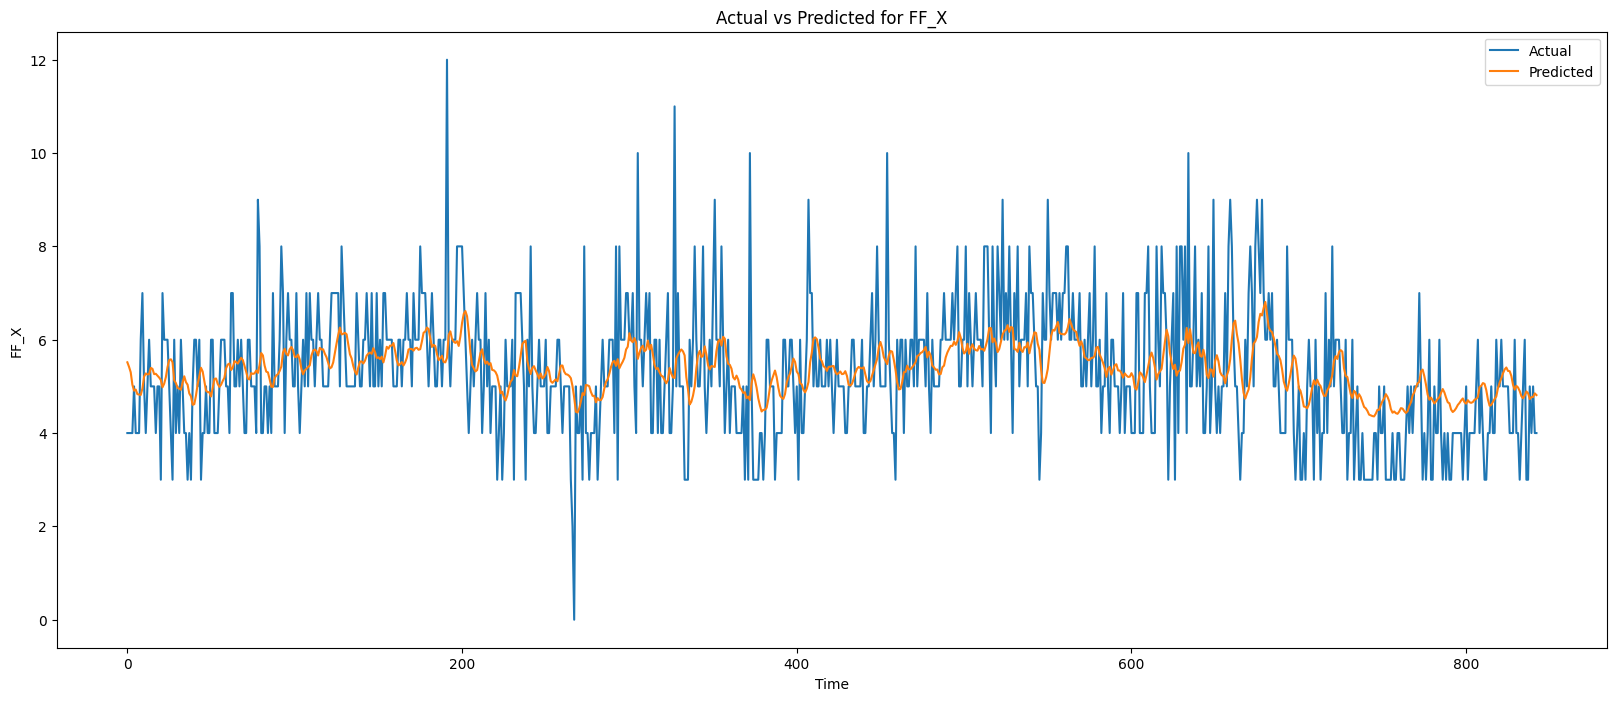

In [50]:
# Predict on test data
y_pred = tuned_model.predict(X_test)

# Define the features list
features = ['FF_X']

# Inverse transform and plot predictions
y_test_inverse, y_hat_inverse = inverse_transform_and_plot(y_test, y_pred,
                                                           scaler, features)

In [51]:
# Create DataFrame with actual and predicted values
predictions_df = create_predictions_dataframe(y_test_inverse, y_hat_inverse, features)
predictions_df.head(10)

,['FF_X'],['FF_X']_pred
0,4.0,5.516
1,4.0,5.419
2,4.0,5.304
3,4.0,5.037
4,5.0,4.908
5,4.0,4.933
6,4.0,4.834
7,4.0,4.825
8,6.0,4.816
9,7.0,4.954


In [52]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

def calculate_metrics(y_true, y_pred, feature_name='FF_X'):
    """
    Menghitung MAE, RMSE, R², dan MAPE untuk 1 fitur target.

    Parameters:
    y_true (np.array): Nilai aktual (2D array: [samples, 1])
    y_pred (np.array): Nilai prediksi (2D array: [samples, 1])
    feature_name (str): Nama fitur target

    Returns:
    pd.DataFrame: DataFrame berisi hasil evaluasi
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Hindari pembagian dengan nol untuk MAPE
    mask = y_true != 0
    if np.any(mask):
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan  # atau 0 atau tampilkan warning

    # Simpan ke DataFrame
    metrics = {
        'feature': [feature_name],
        'MAE': [mae],
        'RMSE': [rmse],
        'R2': [r2],
        'MAPE': [mape]
    }

    return pd.DataFrame(metrics)


In [53]:
# Calculate and display metrics
metrics_df = calculate_metrics(y_test_inverse, y_hat_inverse, features)
metrics_df


,feature,MAE,RMSE,R2,MAPE
0,[FF_X],1.011909,1.300477,0.166893,20.731322


In [54]:
# Fungsi untuk menyimpan model ke dalam file pickle
def save_model_to_pickle(model, filename):
    model.save(filename)  # Menggunakan metode save dari Keras untuk menyimpan model ke file HDF5

# Menyimpan model ke dalam file HDF5
model_filename = 'lstm_model.h5'
save_model_to_pickle(tuned_model, model_filename)
print(f'Model saved to {model_filename}')

Model saved to lstm_model.h5


In [55]:

from tensorflow.keras.models import load_model

model_filename = "lstm_model.h5"

# Jika ingin memuat kembali model LSTM dari file HDF5
def load_model_from_file(filename):
    return load_model(filename)

# Load model
loaded_model = load_model_from_file(model_filename)
print('Model loaded successfully')
loaded_model.summary()

Model loaded successfully


Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_104 (LSTM)                 │ (None, 6, 199)         │       159,996 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 6, 199)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_105 (LSTM)                 │ (None, 199)            │       317,604 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 199)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 116)            │        23,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 1)              │           117 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 500,919 (1.91 MB)

 Trainable params: 500,917 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [56]:
from tensorflow.keras.models import load_model

# Load model LSTM yang telah disimpan sebelumnya
model_filename = "/content/lstm_model.h5"
loaded_model = load_model(model_filename)

# Data uji (pastikan data uji sudah diinisialisasi sebelumnya)
# Select only the 'FF_X' column and drop any potential non-finite values before converting to numpy array
test_data = df_musim[['FF_X']].dropna().values.astype('float32')

# Inisialisasi scaler dan transformasi data uji
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit scaler on the entire 'FF_X' column after dropping potential non-finite values
scaled_data = scaler.fit_transform(df_musim[['FF_X']].dropna())


# Inisialisasi jumlah langkah masukan dan keluaran yang sesuai dengan model LSTM Anda
n_days = 6  # Sesuaikan dengan jumlah langkah masukan yang digunakan saat pelatihan, based on previous cells n_days = 6
n_features = scaled_data.shape[1]

# Prepare initial input sequence for forecasting
# Use the last n_days data points from the scaled data
if len(scaled_data) < n_days:
    print(f"Error: Not enough data for input sequence. Need at least {n_days} data points.")
else:
    input_sequence = scaled_data[-n_days:].reshape((1, n_days, n_features))

    # Prediksi dengan model LSTM
    forecast = []

    # Melakukan prediksi untuk n hari ke depan (iterative forecasting)
    n_forecast_days = 30 # Jumlah hari yang ingin diprediksi
    for _ in range(n_forecast_days):
        # Prediksi hari berikutnya
        predicted = loaded_model.predict(input_sequence)

        # Sanitize the prediction to handle potential non-finite values before inverse transform
        predicted = np.nan_to_num(predicted, nan=np.mean(predicted) if np.any(np.isnan(predicted)) else 0)


        # Store the predicted scaled value
        forecast.append(predicted[0])

        # Update input sequence for the next prediction
        # Remove the oldest data point and add the new prediction
        input_sequence = np.append(input_sequence[:, 1:, :], predicted.reshape(1, 1, n_features), axis=1)


    # Mengonversi daftar hasil prediksi menjadi array numpy
    forecast_array = np.array(forecast)

    # Inverse transform hasil prediksi agar kembali ke skala aslinya
    forecast_inverse = scaler.inverse_transform(forecast_array)
    forecast_inverse = np.abs(forecast_inverse)

    # Mengubah hasil prediksi menjadi DataFrame
    # Generate dates starting from the day after the last date in df_musim
    last_date = df_musim.index[-1]
    date_range = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=n_forecast_days)
    forecast_df = pd.DataFrame(forecast_inverse, index=date_range,
                               columns=['FF_X']) # Use 'FF_X' as column name

    # Display the forecast
    print(f"Forecast for the next {n_forecast_days} days:")
    print(forecast_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

In [57]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for feature in features:
    # Membuat subplot untuk interaktivitas yang lebih baik
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

    # Plot data historis (train)
    fig.add_trace(go.Scatter(x=df_train.index, y=df_train[feature],
                             mode='lines', name='Data Training',
                             line=dict(color='green')),
                   row=1, col=1)

    # Plot data historis (test)
    fig.add_trace(go.Scatter(x=df_test.index, y=df_test[feature],
                             mode='lines', name='Data Test',
                             line=dict(color='orange')),
                  row=1, col=1)

    # Plot data peramalan
    fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df[feature],
                             mode='lines', name='Data Peramalan',
                             line=dict(color='blue')),
                  row=1, col=1)

    # Menambahkan garis koneksi antara df_train dan df_test
    if not df_train.empty and not df_test.empty:
        fig.add_trace(go.Scatter(x=[df_train.index[-1], df_test.index[0]],
                                 y=[df_train[feature].iloc[-1],
                                    df_test[feature].iloc[0]],
                                 mode='lines', line=dict(color='orange'),
                                 showlegend=False), row=1, col=1)

    # Menambahkan garis koneksi antara df_test dan forecast_df
    if not df_test.empty and not forecast_df.empty:
        fig.add_trace(go.Scatter(x=[df_test.index[-1], forecast_df.index[0]],
                                 y=[df_test[feature].iloc[-1],
                                    forecast_df[feature].iloc[0]],
                                 mode='lines', line=dict(color='blue'),
                                 showlegend=False), row=1, col=1)

    # Mengatur layout untuk lebih informatif
    fig.update_layout(
        title=f'Peramalan {feature} untuk {n_forecast_days} ke depan',
        # xaxis_title='Tanggal',
        yaxis_title=feature,
        legend=dict(x=0, y=1, traceorder='normal',orientation='h'),
        autosize=False,
        width=1200,
        height=400
    )

    # Tampilkan plot
    fig.show()

# tcn

In [58]:
pip install keras-tcn


In [59]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
import matplotlib.pyplot as plt
from math import sqrt

In [60]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tcn import TCN
import numpy as np

# Fungsi objective untuk tuning
def objective(trial):
    # 1. Sampling Hyperparameters
    filters = trial.suggest_categorical("filters", [16, 32, 64, 128])
    kernel_size = trial.suggest_categorical("kernel_size", [2, 3, 5])
    dilation_depth = trial.suggest_int("dilation_depth", 2, 5)  # hasil: dilations = [1, 2, ..., 2**(d-1)]
    dilations = [2**i for i in range(dilation_depth)]
    lr = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # 2. Bangun Model
    model = Sequential()
    model.add(TCN(nb_filters=filters,
                  kernel_size=kernel_size,
                  dilations=dilations,
                  input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))

    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='mse',
                  metrics=['mae'])

    # 3. Training Model
    history = model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        epochs=20,
                        batch_size=32,
                        verbose=0)

    # 4. Evaluasi
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    return mae  # Minimize validation MAE

# 5. Jalankan Optimasi
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# 6. Tampilkan hasil terbaik
print("Best Trial:")
print(f"  MAE: {study.best_trial.value}")
print("  Best Parameters:")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")


[I 2025-07-21 08:33:06,858] A new study created in memory with name: no-name-fc4d3858-27a5-43d1-9268-7832e302dbef
/tmp/ipython-input-60-312215669.py:15: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.

[I 2025-07-21 08:33:57,953] Trial 0 finished with value: 0.055184680968523026 and parameters: {'filters': 64, 'kernel_size': 3, 'dilation_depth': 3, 'learning_rate': 0.00836851152316911}. Best is trial 0 with value: 0.055184680968523026.
[I 2025-07-21 08:35:56,054] Trial 1 finished with value: 0.05443323776125908 and parameters: {'filters': 128, 'kernel_size': 5, 'dilation_depth': 3, 'learning_r

Best Trial:
  MAE: 0.048599354922771454
  Best Parameters:
    filters: 16
    kernel_size: 5
    dilation_depth: 3
    learning_rate: 0.00027978014550521257


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from tensorflow.keras.optimizers import Adam

# Buat model TCN
model_tcn = Sequential()
model_tcn.add(TCN(
    input_shape=(X_train.shape[1], X_train.shape[2]),  # (timesteps, features)
    nb_filters=64,              # jumlah filter
    kernel_size=5,              # panjang filter
    dilations=[1, 2, 4],        # dilatasi bertingkat
    activation='relu'
))
model_tcn.add(Dense(1))  # output 1 karena n_features = 1 (yaitu FF_X)

# Compile model
optimizer = Adam(learning_rate=0.0007)
model_tcn.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Tampilkan arsitektur model
model_tcn.summary()


Model: "sequential_103"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ tcn_50 (TCN)                    │ (None, 64)             │       103,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_157 (Dense)               │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 103,297 (403.50 KB)

 Trainable params: 103,297 (403.50 KB)

 Non-trainable params: 0 (0.00 B)

Model TCN dibangun menggunakan arsitektur sequential yang terdiri dari satu lapisan Temporal Convolutional Network (TCN) dengan 16 filter, kernel size 5, dan dilasi bertingkat [1, 2], serta menggunakan fungsi aktivasi ReLU. Lapisan ini diikuti oleh satu lapisan Dense yang menghasilkan output tunggal. Model dikompilasi menggunakan optimizer Adam dengan learning rate 0.003, serta loss function MSE dan metrik MAE.

In [62]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_tcn = model_tcn.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    shuffle=False,
    verbose=1
)


Epoch 1/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0186 - mae: 0.0999 - val_loss: 0.0042 - val_mae: 0.0511
Epoch 2/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0062 - mae: 0.0587 - val_loss: 0.0039 - val_mae: 0.0471
Epoch 3/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0065 - mae: 0.0605 - val_loss: 0.0040 - val_mae: 0.0473
Epoch 4/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0065 - mae: 0.0610 - val_loss: 0.0039 - val_mae: 0.0476
Epoch 5/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0062 - mae: 0.0592 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 6/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0061 - mae: 0.0585 - val_loss: 0.0039 - val_mae: 0.0487
Epoch 7/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0060 - mae: 0.0579 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 8/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0060 - mae: 0.0580 - val_loss: 0.0039 - val_mae: 0.0490
Epoch 9/50
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0035 - mae: 0.0457
Test Loss (TCN): [0.003856423543766141, 0.04796060547232628]


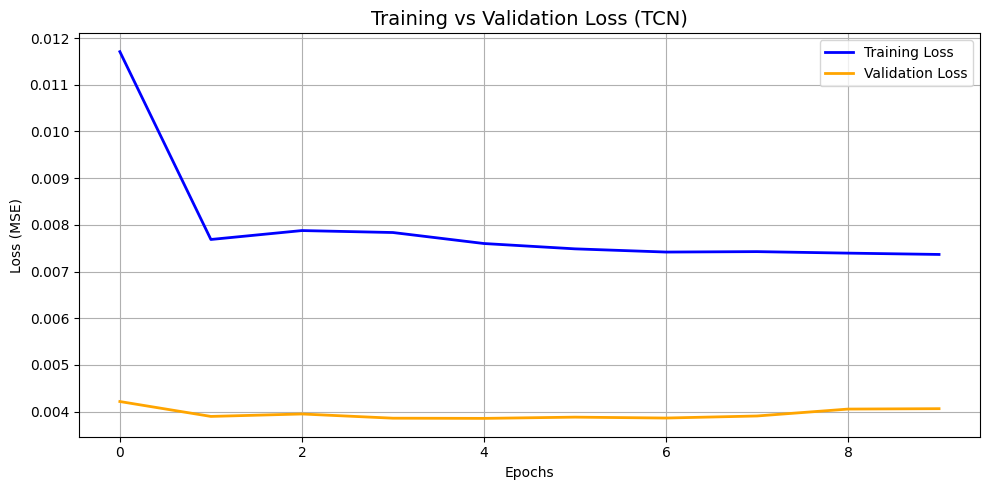

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tcn import TCN
from tensorflow.keras.optimizers import Adam

# --- Evaluasi model ---
test_loss = model_tcn.evaluate(X_test, y_test)
print(f'Test Loss (TCN): {test_loss}')

# --- Visualisasi Loss ---
plt.figure(figsize=(10, 5))
plt.plot(history_tcn.history['loss'], label='Training Loss', color='blue', linewidth=2)
plt.plot(history_tcn.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training vs Validation Loss (TCN)', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


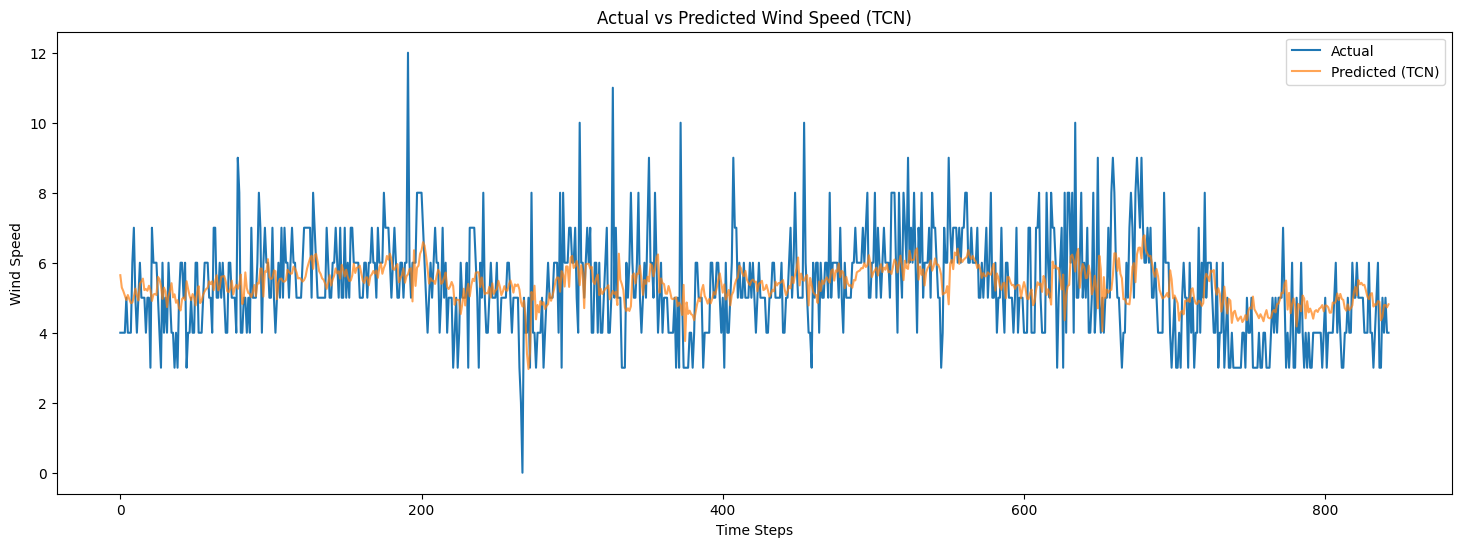

  feature       MAE      RMSE        R2      MAPE
0    FF_X  1.007173  1.304102  0.162242  20.52565


In [64]:
# --- Prediksi dengan model TCN ---
y_pred_tcn = model_tcn.predict(X_test)

# --- Invers transformasi hasil prediksi dan aktual ---
y_test_inverse_tcn = scaler.inverse_transform(y_test)
y_pred_inverse_tcn = scaler.inverse_transform(y_pred_tcn)

# --- Plot hasil prediksi vs aktual ---
import matplotlib.pyplot as plt

plt.figure(figsize=(18,6))
plt.plot(y_test_inverse_tcn, label='Actual')
plt.plot(y_pred_inverse_tcn, label='Predicted (TCN)', alpha=0.7)
plt.title("Actual vs Predicted Wind Speed (TCN)")
plt.xlabel("Time Steps")
plt.ylabel("Wind Speed")
plt.legend()
plt.show()

# --- Hitung metrik evaluasi ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(y_true, y_pred, feature_name='FF_X'):
    """
    Menghitung MAE, RMSE, R², dan MAPE untuk 1 fitur target.
    """
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan

    return pd.DataFrame({
        'feature': [feature_name],
        'MAE': [mae],
        'RMSE': [rmse],
        'R2': [r2],
        'MAPE': [mape]
    })

# --- Tampilkan metrik ---
metrics_tcn = calculate_metrics(y_test_inverse_tcn, y_pred_inverse_tcn, feature_name='FF_X')
print(metrics_tcn)


In [65]:
# --- Simpan model TCN setelah training dan evaluasi ---
model_tcn.save('tcn_model_final.h5')
print("Model TCN berhasil disimpan sebagai tcn_model_final.h5")


Model TCN berhasil disimpan sebagai tcn_model_final.h5


In [66]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

# --- Load Model TCN ---
model_tcn = load_model("tcn_model_final.h5", compile=False)  # ganti path jika perlu

# --- Persiapkan data FF_X ---
test_data = df_musim[['FF_X']].dropna().values.astype('float32')

# --- Scaling data ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(test_data)

# --- Konfigurasi input sesuai model TCN ---
n_days = 6  # panjang input sequence (timesteps) sesuai saat pelatihan
n_features = scaled_data.shape[1]  # biasanya = 1 jika hanya 'FF_X'

# --- Cek apakah data cukup ---
if len(scaled_data) < n_days:
    print(f"Error: Minimal butuh {n_days} data untuk prediksi.")
else:
    input_sequence = scaled_data[-n_days:].reshape((1, n_days, n_features))  # shape (1, timesteps, features)

    forecast = []
    n_forecast_days = 30  # jumlah hari ke depan yang ingin diprediksi

    for _ in range(n_forecast_days):
        # Prediksi dengan model TCN
        predicted = model_tcn.predict(input_sequence, verbose=0)

        # Tangani jika hasil prediksi mengandung nilai NaN
        predicted = np.nan_to_num(predicted, nan=np.mean(predicted) if np.any(np.isnan(predicted)) else 0)

        # Simpan hasil prediksi
        forecast.append(predicted[0])

        # Update input sequence (rolling window)
        input_sequence = np.append(input_sequence[:, 1:, :], predicted.reshape(1, 1, n_features), axis=1)

    # --- Inverse transform ke skala asli ---
    forecast_array = np.array(forecast)
    forecast_inverse = scaler.inverse_transform(forecast_array)
    forecast_inverse = np.abs(forecast_inverse)  # untuk menghindari nilai negatif

    # --- Buat DataFrame hasil prediksi ---
    last_date = df_musim.index[-1]
    date_range = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=n_forecast_days)

    forecast_df = pd.DataFrame(forecast_inverse, index=date_range, columns=['FF_X'])

    # --- Tampilkan hasil prediksi ---
    print(f"Forecast TCN untuk {n_forecast_days} hari ke depan:")
    print(forecast_df)


Forecast TCN untuk 30 hari ke depan:
                FF_X
2025-07-21  4.887132
2025-07-22  5.090039
2025-07-23  5.134755
2025-07-24  5.113914
2025-07-25  5.221577
2025-07-26  5.282609
2025-07-27  5.346366
2025-07-28  5.352307
2025-07-29  5.369434
2025-07-30  5.401901
2025-07-31  5.420017
2025-08-01  5.429819
2025-08-02  5.435326
2025-08-03  5.442431
2025-08-04  5.449708
2025-08-05  5.454342
2025-08-06  5.457320
2025-08-07  5.459578
2025-08-08  5.461778
2025-08-09  5.463582
2025-08-10  5.464858
2025-08-11  5.465773
2025-08-12  5.466516
2025-08-13  5.467142
2025-08-14  5.467633
2025-08-15  5.467998
2025-08-16  5.468274
2025-08-17  5.468496
2025-08-18  5.468677
2025-08-19  5.468818


In [67]:
# 7. Bangun ulang model terbaik dengan parameter terbaik
best_params = study.best_trial.params
filters = best_params['filters']
kernel_size = best_params['kernel_size']
dilation_depth = best_params['dilation_depth']
dilations = [2**i for i in range(dilation_depth)]
lr = best_params['learning_rate']

# Buat model ulang dengan parameter terbaik
best_model = Sequential()
best_model.add(TCN(nb_filters=filters,
                   kernel_size=kernel_size,
                   dilations=dilations,
                   input_shape=(X_train.shape[1], X_train.shape[2])))
best_model.add(Dense(1))

best_model.compile(optimizer=Adam(learning_rate=lr),
                   loss='mse',
                   metrics=['mae'])

# 8. Latih ulang model (opsional tapi direkomendasikan)
best_model.fit(X_train, y_train,
               validation_data=(X_test, y_test),
               epochs=20,
               batch_size=32,
               verbose=1)

# 9. Simpan model ke file .h5
best_model.save('tcn_model_final.h5')
print("Model terbaik disimpan ke 'best_tcn_model.h5'")


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/tcn/tcn.py:268: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



106/106 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0151 - mae: 0.0917 - val_loss: 0.0046 - val_mae: 0.0518
Epoch 2/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0083 - mae: 0.0653 - val_loss: 0.0041 - val_mae: 0.0489
Epoch 3/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0075 - mae: 0.0622 - val_loss: 0.0040 - val_mae: 0.0481
Epoch 4/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0071 - mae: 0.0609 - val_loss: 0.0040 - val_mae: 0.0481
Epoch 5/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0070 - mae: 0.0603 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 6/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0069 - mae: 0.0599 - val_loss: 0.0039 - val_mae: 0.0480
Epoch 7/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0068 - mae: 0.0597 - val_loss: 0.0039 - val_mae: 0.0479
Epoch 8/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067 - mae: 0.0596 - val_loss: 0.0039 - val_mae: 0.0482
Epoch 9/20
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067

Model terbaik disimpan ke 'best_tcn_model.h5'


In [68]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Daftar fitur yang akan divisualisasikan (misalnya hanya 'FF_X')
features = ['FF_X']  # Sesuaikan jika kamu punya lebih dari satu fitur

for feature in features:
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

    # --- Plot data training ---
    if not df_train.empty:
        fig.add_trace(go.Scatter(x=df_train.index, y=df_train[feature],
                                 mode='lines', name='Data Training',
                                 line=dict(color='green')), row=1, col=1)

    # --- Plot data testing ---
    if not df_test.empty:
        fig.add_trace(go.Scatter(x=df_test.index, y=df_test[feature],
                                 mode='lines', name='Data Test',
                                 line=dict(color='orange')), row=1, col=1)

    # --- Plot hasil forecast TCN ---
    if not forecast_df.empty:
        fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df[feature],
                                 mode='lines', name='Data Peramalan (TCN)',
                                 line=dict(color='blue')), row=1, col=1)

    # --- Garis koneksi antara training dan test ---
    if not df_train.empty and not df_test.empty:
        fig.add_trace(go.Scatter(
            x=[df_train.index[-1], df_test.index[0]],
            y=[df_train[feature].iloc[-1], df_test[feature].iloc[0]],
            mode='lines', line=dict(color='orange', dash='dot'),
            showlegend=False), row=1, col=1)

    # --- Garis koneksi antara test dan forecast ---
    if not df_test.empty and not forecast_df.empty:
        fig.add_trace(go.Scatter(
            x=[df_test.index[-1], forecast_df.index[0]],
            y=[df_test[feature].iloc[-1], forecast_df[feature].iloc[0]],
            mode='lines', line=dict(color='blue', dash='dot'),
            showlegend=False), row=1, col=1)

    # --- Layout tampilan ---
    fig.update_layout(
        title=f'Peramalan {feature} Menggunakan Model TCN Selama {n_forecast_days} Hari',
        yaxis_title=feature,
        legend=dict(x=0, y=1.1, orientation='h'),
        autosize=False,
        width=1200,
        height=450
    )

    fig.show()


# RBFNN

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

In [70]:
train_X_rbf = train_X.reshape((train_X.shape[0], train_X.shape[1]))  # Flatten to 2D
test_X_rbf = test_X.reshape((test_X.shape[0], test_X.shape[1]))

In [71]:
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import numpy as np

class RBFNN:
    def __init__(self, n_centers=10, spread=None):
        self.n_centers = n_centers
        self.spread = spread  # bisa None atau float
        self.centers = None
        self.beta = None
        self.linear_model = None

    def _kernel(self, X, centers):
        G = np.zeros((X.shape[0], centers.shape[0]))
        for i, center in enumerate(centers):
            # RBF Gaussian kernel
            G[:, i] = np.exp(-self.beta * np.linalg.norm(X - center, axis=1) ** 2)
        return G

    def fit(self, X, y):
        # Clustering untuk menentukan center
        kmeans = KMeans(n_clusters=self.n_centers, random_state=42)
        kmeans.fit(X)
        self.centers = kmeans.cluster_centers_

        # Tentukan beta (spread Gaussian) secara manual atau otomatis
        if self.spread is not None:
            self.beta = 1 / (2 * (self.spread ** 2))
        else:
            d_max = np.max([np.linalg.norm(c1 - c2) for c1 in self.centers for c2 in self.centers])
            self.beta = 1 / (2 * (d_max ** 2))  # Default: pakai d_max antar center

        # Transformasi fitur
        G = self._kernel(X, self.centers)

        # Linear regression pada output
        self.linear_model = LinearRegression()
        self.linear_model.fit(G, y)

    def predict(self, X):
        G = self._kernel(X, self.centers)
        return self.linear_model.predict(G)


Model RBFNN dalam kode ini terdiri dari dua tahap utama: pertama, data dilatih menggunakan KMeans untuk menentukan pusat-pusat RBF. Selanjutnya, fungsi Gaussian digunakan untuk menghitung aktivasi berdasarkan jarak antara input dan pusat tersebut. Parameter β dihitung dari jarak maksimum antar pusat untuk mengatur lebar fungsi Gaussian. Aktivasi ini kemudian digunakan sebagai input untuk model regresi linear, yang akan memetakan ke output target. Proses prediksi dilakukan dengan menghitung aktivasi terhadap data baru, lalu diproses oleh model linear untuk menghasilkan output prediksi.

In [72]:
# --- FLATTEN INPUT (karena RBFNN hanya bisa 2D) ---
X_train_rbf = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_rbf = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# --- TRAIN RBFNN ---
rbf_model = RBFNN(n_centers=10)
rbf_model.fit(X_train_rbf, y_train)

# --- PREDICT ---
y_pred_rbf = rbf_model.predict(X_test_rbf)

# --- INVERSE TRANSFORM (balikkan ke skala asli) ---
y_test_inverse_rbf = scaler.inverse_transform(y_test)
y_pred_inverse_rbf = scaler.inverse_transform(y_pred_rbf)

# --- EVALUASI ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Fungsi evaluasi
def evaluate(y_true, y_pred, feature_name='FF_X'):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mask = y_true != 0
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100 if np.any(mask) else np.nan
    return {
        'Feature': feature_name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'MAPE': mape
    }

# Hitung metrik evaluasi
metrics_rbf = evaluate(y_test_inverse_rbf, y_pred_inverse_rbf)
print(metrics_rbf)


{'Feature': 'FF_X', 'MAE': 1.1859694497100346, 'RMSE': np.float64(1.4605593845821498), 'R2': -0.050833304524385614, 'MAPE': np.float64(26.30556435205636)}


In [73]:
import joblib
joblib.dump(rbf_model, 'rbfnn_model.pkl')
print("Model RBFNN telah disimpan ke rbfnn_model.pkl")

Model RBFNN telah disimpan ke rbfnn_model.pkl


In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib  # jika model disimpan dengan joblib atau pickle

# --- Load Model RBFNN ---
# Misal disimpan sebagai file .pkl
rbfnn_model = joblib.load("/content/rbfnn_model.pkl")  # Ganti path jika perlu

# --- Persiapkan data FF_X ---
test_data = df_musim[['FF_X']].dropna().values.astype('float32')

# --- Scaling data ---
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(test_data)

# --- Konfigurasi input untuk RBFNN ---
n_days = 6  # jumlah lag input, sesuai pelatihan
n_forecast_days = 30
n_features = scaled_data.shape[1]

# --- Cek apakah data cukup ---
if len(scaled_data) < n_days:
    print(f"Error: Minimal butuh {n_days} data untuk prediksi.")
else:
    input_sequence = scaled_data[-n_days:]  # shape (n_days,)

    forecast = []

    for _ in range(n_forecast_days):
        # RBFNN biasanya menggunakan input flat, reshape ke (1, n_days)
        input_rbf = input_sequence.reshape(1, -1)  # (1, n_days)

        # Prediksi hari berikutnya
        predicted = rbfnn_model.predict(input_rbf)

        # Tangani jika hasil prediksi NaN
        predicted = np.nan_to_num(predicted, nan=np.mean(predicted) if np.any(np.isnan(predicted)) else 0)

        # Simpan hasil prediksi
        forecast.append(predicted[0])

        # Update input_sequence (rolling window)
        input_sequence = np.append(input_sequence[1:], predicted).reshape(-1)

    # --- Inverse transform hasil prediksi ---
    forecast_array = np.array(forecast).reshape(-1, 1)
    forecast_inverse = scaler.inverse_transform(forecast_array)
    forecast_inverse = np.abs(forecast_inverse)

    # --- Buat DataFrame hasil prediksi ---
    last_date = df_musim.index[-1]
    date_range = pd.date_range(start=last_date + pd.Timedelta(days=1),
                               periods=n_forecast_days)
    forecast_df = pd.DataFrame(forecast_inverse, index=date_range, columns=['FF_X'])

    # --- Tampilkan hasil prediksi ---
    print(f"Forecast RBFNN untuk {n_forecast_days} hari ke depan:")
    print(forecast_df)


Forecast RBFNN untuk 30 hari ke depan:
                FF_X
2025-07-21  5.559991
2025-07-22  5.698073
2025-07-23  5.663894
2025-07-24  5.801569
2025-07-25  5.823995
2025-07-26  5.859178
2025-07-27  6.019658
2025-07-28  6.074818
2025-07-29  6.111784
2025-07-30  6.158381
2025-07-31  6.193675
2025-08-01  6.226730
2025-08-02  6.266123
2025-08-03  6.294509
2025-08-04  6.319426
2025-08-05  6.343187
2025-08-06  6.364392
2025-08-07  6.383930
2025-08-08  6.402505
2025-08-09  6.418907
2025-08-10  6.433920
2025-08-11  6.447819
2025-08-12  6.460589
2025-08-13  6.472386
2025-08-14  6.483328
2025-08-15  6.493387
2025-08-16  6.502693
2025-08-17  6.511319
2025-08-18  6.519313
2025-08-19  6.526730


In [81]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Misalnya fitur yang diprediksi adalah hanya 'FF_X'
features = ['FF_X']  # Ganti/extend jika lebih dari satu fitur

for feature in features:
    fig = make_subplots(rows=1, cols=1, shared_xaxes=True)

    # --- Plot Data Training ---
    if not df_train.empty:
        fig.add_trace(go.Scatter(x=df_train.index, y=df_train[feature],
                                 mode='lines', name='Data Training',
                                 line=dict(color='green')), row=1, col=1)

    # --- Plot Data Testing ---
    if not df_test.empty:
        fig.add_trace(go.Scatter(x=df_test.index, y=df_test[feature],
                                 mode='lines', name='Data Testing',
                                 line=dict(color='orange')), row=1, col=1)

    # --- Plot Hasil Prediksi RBFNN ---
    if not forecast_df.empty:
        fig.add_trace(go.Scatter(x=forecast_df.index, y=forecast_df[feature],
                                 mode='lines', name='Hasil Prediksi (RBFNN)',
                                 line=dict(color='red')), row=1, col=1)

    # --- Garis koneksi antara train dan test ---
    if not df_train.empty and not df_test.empty:
        fig.add_trace(go.Scatter(
            x=[df_train.index[-1], df_test.index[0]],
            y=[df_train[feature].iloc[-1], df_test[feature].iloc[0]],
            mode='lines', line=dict(color='orange', dash='dot'),
            showlegend=False), row=1, col=1)

    # --- Garis koneksi antara test dan prediksi ---
    if not df_test.empty and not forecast_df.empty:
        fig.add_trace(go.Scatter(
            x=[df_test.index[-1], forecast_df.index[0]],
            y=[df_test[feature].iloc[-1], forecast_df[feature].iloc[0]],
            mode='lines', line=dict(color='red', dash='dot'),
            showlegend=False), row=1, col=1)

    # --- Layout visualisasi ---
    fig.update_layout(
        title=f'Peramalan {feature} Menggunakan Model RBFNN Selama {n_forecast_days} Hari',
        yaxis_title=feature,
        legend=dict(x=0, y=1.1, orientation='h'),
        autosize=False,
        width=1200,
        height=450
    )

    fig.show()


In [76]:
import optuna
from sklearn.metrics import mean_squared_error

# FLATTEN INPUT (karena RBFNN hanya bisa 2D)
X_train_rbf = X_train.reshape((X_train.shape[0], X_train.shape[1]))
X_test_rbf = X_test.reshape((X_test.shape[0], X_test.shape[1]))

# Fungsi objektif untuk Optuna
def objective(trial):
    n_centers = trial.suggest_int("n_centers", 5, 50)
    spread = trial.suggest_float("spread", 0.1, 2.0)

    # Buat dan latih model
    model = RBFNN(n_centers=n_centers, spread=spread)
    model.fit(X_train_rbf, y_train)

    # Prediksi dan hitung MSE pada data uji
    y_pred = model.predict(X_test_rbf)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Buat dan jalankan studi
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# Tampilkan hasil terbaik
print("Best parameters:")
print(study.best_params)

# Setelah tuning, buat model terbaik dan evaluasi ulang
best_params = study.best_params
best_model = RBFNN(n_centers=best_params['n_centers'], spread=best_params['spread'])
best_model.fit(X_train_rbf, y_train)
y_pred_best = best_model.predict(X_test_rbf)

# Inverse transform hasil prediksi dan aktual
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred_best)

# Evaluasi
metrics_best_rbf = evaluate(y_test_inv, y_pred_inv)
print("\nEvaluasi RBFNN dengan hyperparameter terbaik:")
print(metrics_best_rbf)


[I 2025-07-21 09:06:52,861] A new study created in memory with name: no-name-7715132d-e32a-461a-91d3-4a7104f85b7d
[I 2025-07-21 09:06:53,157] Trial 0 finished with value: 0.004625925884325892 and parameters: {'n_centers': 41, 'spread': 0.9601756169844113}. Best is trial 0 with value: 0.004625925884325892.
[I 2025-07-21 09:06:53,201] Trial 1 finished with value: 0.0040429809452001255 and parameters: {'n_centers': 5, 'spread': 1.9883378123357884}. Best is trial 1 with value: 0.0040429809452001255.
[I 2025-07-21 09:06:53,320] Trial 2 finished with value: 0.0047133853803151314 and parameters: {'n_centers': 44, 'spread': 1.605689990520395}. Best is trial 1 with value: 0.0040429809452001255.
[I 2025-07-21 09:06:53,363] Trial 3 finished with value: 0.004753903778765318 and parameters: {'n_centers': 15, 'spread': 0.40497901865698405}. Best is trial 1 with value: 0.0040429809452001255.
[I 2025-07-21 09:06:53,458] Trial 4 finished with value: 0.004576439821056276 and parameters: {'n_centers': 40

Best parameters:
{'n_centers': 6, 'spread': 1.914738027566196}

Evaluasi RBFNN dengan hyperparameter terbaik:
{'Feature': 'FF_X', 'MAE': 1.068923688803444, 'RMSE': np.float64(1.3349210177594624), 'R2': 0.1221778578122702, 'MAPE': np.float64(22.693977647731014)}


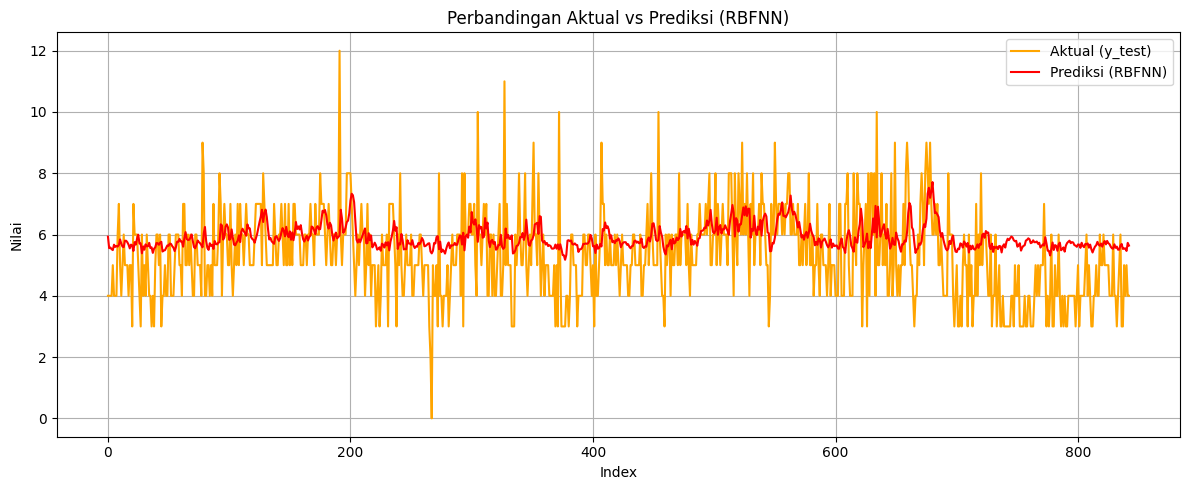

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(y_test_inverse_rbf, label='Aktual (y_test)', color='orange')
plt.plot(y_pred_inverse_rbf, label='Prediksi (RBFNN)', color='red')
plt.title('Perbandingan Aktual vs Prediksi (RBFNN)')
plt.xlabel('Index')
plt.ylabel('Nilai')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


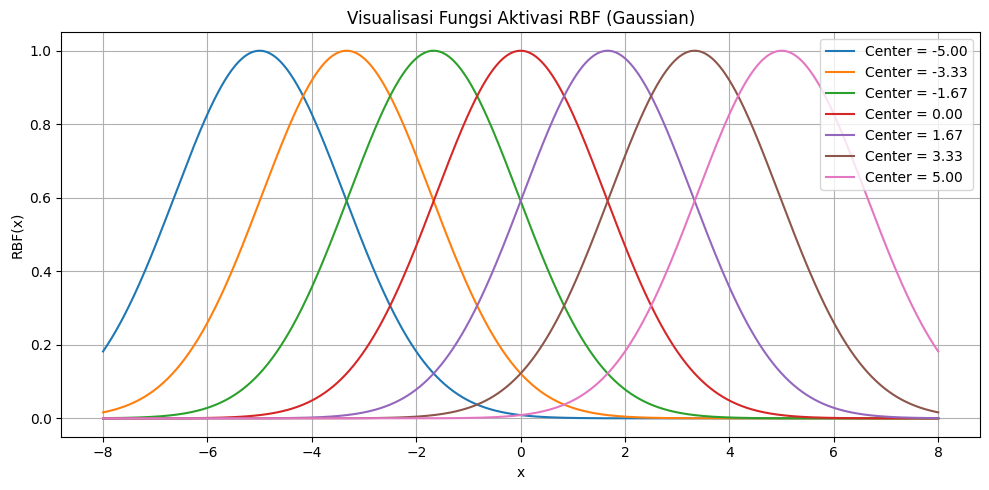

In [78]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter
n_centers = 7
spread = 1.6251160845165642

# Titik pusat (distribusikan merata dari -5 ke 5)
centers = np.linspace(-5, 5, n_centers)

# Domain nilai x
x = np.linspace(-8, 8, 1000)

# Fungsi aktivasi Gaussian RBF
def rbf(x, center, spread):
    return np.exp(-((x - center)**2) / (2 * spread**2))

# Plot semua fungsi RBF
plt.figure(figsize=(10, 5))
for c in centers:
    plt.plot(x, rbf(x, c, spread), label=f'Center = {c:.2f}')

plt.title('Visualisasi Fungsi Aktivasi RBF (Gaussian)')
plt.xlabel('x')
plt.ylabel('RBF(x)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


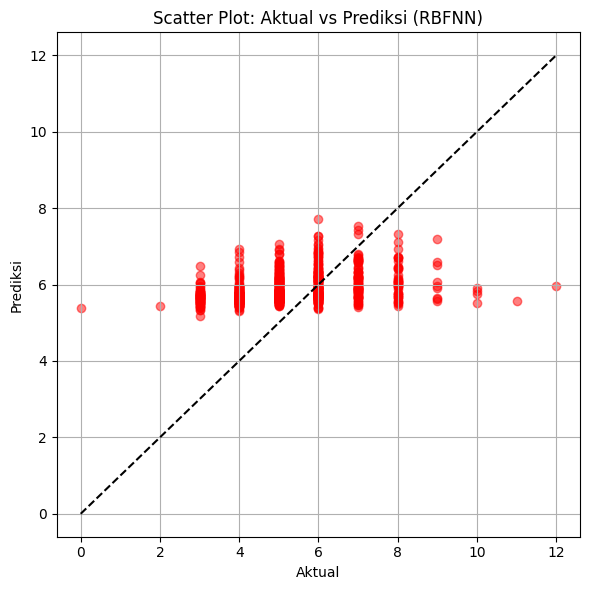

In [79]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_inverse_rbf, y_pred_inverse_rbf, alpha=0.5, color='red')
plt.plot([y_test_inverse_rbf.min(), y_test_inverse_rbf.max()],
         [y_test_inverse_rbf.min(), y_test_inverse_rbf.max()], 'k--')
plt.xlabel('Aktual')
plt.ylabel('Prediksi')
plt.title('Scatter Plot: Aktual vs Prediksi (RBFNN)')
plt.grid(True)
plt.tight_layout()
plt.show()


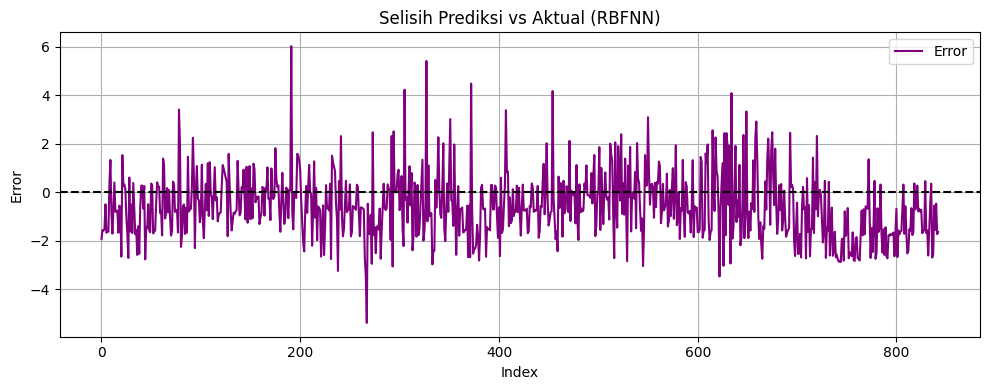

In [80]:
error = y_test_inverse_rbf.flatten() - y_pred_inverse_rbf.flatten()

plt.figure(figsize=(10, 4))
plt.plot(error, label='Error', color='purple')
plt.title('Selisih Prediksi vs Aktual (RBFNN)')
plt.xlabel('Index')
plt.ylabel('Error')
plt.axhline(y=0, color='black', linestyle='--')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
